In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import json
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.utils as vutils
import matplotlib.gridspec as gridspec

plt.style.use('fivethirtyeight')
sns.set_palette("viridis")

###  Task 1: Baseline Evaluation of ResNet-34 on ImageNet-1K Subset

In this task, we evaluated a **pre-trained ResNet-34 model** on a subset of the ImageNet-1K dataset containing 500 test images from 100 classes. Images were normalized using standard ImageNet mean and standard deviation values:
```python
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]


In [2]:
# Configuration settings
class Config:
    # Normalization constants for ImageNet
    MEAN_NORMS = np.array([0.485, 0.456, 0.406])
    STD_NORMS = np.array([0.229, 0.224, 0.225])
    
    # FGSM attack parameters
    EPSILON = 0.02
    
    # Data parameters
    BATCH_SIZE = 32

    DATASET_PATH = "/kaggle/input/testdataset/TestDataSet"
    ADV_OUTPUT_DIR = "./adversarial_images"
    
    MAX_EXAMPLES_TO_SHOW = 5
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(Config.ADV_OUTPUT_DIR, exist_ok=True)

# Helper functions for image normalization
class ImageUtils:
    @staticmethod
    def unnormalize(tensor, mean=Config.MEAN_NORMS, std=Config.STD_NORMS):
        """Convert normalized image tensor to original scale [0,1]"""
        if tensor.dim() == 3:
            tensor = tensor.unsqueeze(0)
            
        mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(tensor.device)
        std = torch.tensor(std).reshape(1, 3, 1, 1).to(tensor.device)
        return tensor * std + mean
    
    @staticmethod
    def renormalize(tensor, mean=Config.MEAN_NORMS, std=Config.STD_NORMS):
        """Convert image tensor to normalized scale"""
        if tensor.dim() == 3:
            tensor = tensor.unsqueeze(0)
            
        mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(tensor.device)
        std = torch.tensor(std).reshape(1, 3, 1, 1).to(tensor.device)
        return (tensor - mean) / std

# Custom dataset class that corrects labels
class CorrectedLabelDataset(Dataset):
    def __init__(self, base_dataset, idx_to_label):
        self.base_dataset = base_dataset
        self.idx_to_label = idx_to_label
        
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        image, folder_idx = self.base_dataset[idx]
        correct_label = self.idx_to_label[folder_idx]
        return image, int(correct_label)

class DataManager:
    def __init__(self, data_path=Config.DATASET_PATH):
        self.data_path = data_path
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=Config.MEAN_NORMS, std=Config.STD_NORMS)
        ])
        
        with open(os.path.join(data_path, "labels_list.json"), 'r') as f:
            label_lines = json.load(f)
        
        self.imagenet_labels = [int(line.split(":")[0]) for line in label_lines]
        self.class_names = [line.split(":")[1].strip() for line in label_lines]
        
        # Create mapping from folder index to actual ImageNet label
        self.image_folder_dataset = datasets.ImageFolder(root=data_path, transform=self.transform)
        self.idx_to_imagenet = {i: self.imagenet_labels[i] for i in range(len(self.imagenet_labels))}
        
        # Create the corrected dataset
        self.corrected_dataset = CorrectedLabelDataset(self.image_folder_dataset, self.idx_to_imagenet)
        
    def get_data_loader(self, batch_size=Config.BATCH_SIZE, shuffle=False):
        return DataLoader(self.corrected_dataset, batch_size=batch_size, shuffle=shuffle)
    
    def get_class_name(self, class_idx):
        """Convert class index to human-readable name"""
        if 401 <= class_idx <= 500:
            return self.class_names[class_idx - 401]
        return f"Class {class_idx}"

class ModelEvaluator:
    def __init__(self, model, device=Config.DEVICE):
        self.model = model
        self.device = device
    
    @staticmethod
    def topk_accuracy(output, target, topk=(1, 5)):
        """Compute the topk accuracy"""
        maxk = max(topk)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        return [correct[:k].reshape(-1).float().sum(0, keepdim=True).item() for k in topk]
    
    def evaluate(self, data_loader):
        self.model.eval()
        top1_correct = 0
        top5_correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(data_loader, desc="Evaluating model"):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                top1, top5 = self.topk_accuracy(outputs, labels, topk=(1, 5))
                top1_correct += top1
                top5_correct += top5
                total += labels.size(0)
        
        return {
            "top1": 100 * top1_correct / total,
            "top5": 100 * top5_correct / total,
            "samples": total
        }

class AdversarialAttacker:
    def __init__(self, model, device=Config.DEVICE, epsilon=Config.EPSILON):
        self.model = model
        self.device = device
        self.epsilon = epsilon
        self.loss_fn = nn.CrossEntropyLoss()
    
    def generate_fgsm_attack(self, data_loader, output_dir=Config.ADV_OUTPUT_DIR):
        self.model.eval()
        adversarial_images = []
        true_labels = []
        
        for i, (images, labels) in enumerate(tqdm(data_loader, desc="Generating adversarial examples")):
            images, labels = images.to(self.device), labels.to(self.device)
            images.requires_grad = True
            
            # Forward pass
            outputs = self.model(images)
            loss = self.loss_fn(outputs, labels)
            
            # Backward pass
            self.model.zero_grad()
            loss.backward()
            grad = images.grad.data
            
            # Generate adversarial examples
            images_unnorm = ImageUtils.unnormalize(images)
            adv_unnorm = images_unnorm + self.epsilon * grad.sign()
            adv_unnorm = torch.clamp(adv_unnorm, 0, 1)
            adv_images = ImageUtils.renormalize(adv_unnorm).float()

            
            adversarial_images.append(adv_images.detach().cpu())
            true_labels.append(labels.detach().cpu())
            
            # Save individual images
            for j in range(images.size(0)):
                img_path = os.path.join(output_dir, f"adv_img_{i*data_loader.batch_size + j}.png")
                adv_img = adv_unnorm[j].detach().cpu()
                adv_img_pil = transforms.ToPILImage()(adv_img)
                adv_img_pil.save(img_path)
        
        # Create a dataset with adversarial examples
        adv_tensor = torch.cat(adversarial_images).float()
        label_tensor = torch.cat(true_labels)
        adv_dataset = TensorDataset(adv_tensor, label_tensor)
        
        return adv_dataset

class Visualizer:
    def __init__(self, model, data_manager, device=Config.DEVICE):
        self.model = model
        self.data_manager = data_manager
        self.device = device
        self.loss_fn = nn.CrossEntropyLoss()
    
    def visualize_adversarial_examples(self, data_loader, epsilon=Config.EPSILON, max_examples=Config.MAX_EXAMPLES_TO_SHOW):
        self.model.eval()
        shown = 0
        
        for images, labels in data_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            images.requires_grad = True
            
            outputs = self.model(images)
            loss = self.loss_fn(outputs, labels)
            
            self.model.zero_grad()
            loss.backward()
            grad = images.grad.data
            
            # Generate adversarial examples
            pixel_images = ImageUtils.unnormalize(images)
            adv_pixel = torch.clamp(pixel_images + epsilon * grad.sign(), 0, 1)
            adv_norm = ImageUtils.renormalize(adv_pixel).float()
            
            # Get predictions on adversarial examples
            with torch.no_grad():
                logits = self.model(adv_norm)
                probs = F.softmax(logits, dim=1)
                preds = probs.argmax(dim=1)
                top5_vals, top5_classes = probs.topk(5, dim=1)
            
            # Visualize examples where the attack succeeded
            for i in range(images.size(0)):
                if preds[i].item() != labels[i].item():
                    self._plot_example(
                        original=pixel_images[i],
                        adversarial=adv_pixel[i],
                        true_label=labels[i].item(),
                        pred_label=preds[i].item(),
                        top5_probs=top5_vals[i].cpu().numpy(),
                        top5_classes=top5_classes[i].cpu().numpy()
                    )
                    
                    shown += 1
                    if shown >= max_examples:
                        return
            
            if shown >= max_examples:
                return
    
    def _plot_example(self, original, adversarial, true_label, pred_label, top5_probs, top5_classes):
        orig_img = original.detach().cpu().permute(1, 2, 0).numpy().clip(0, 1)
        adv_img = adversarial.detach().cpu().permute(1, 2, 0).numpy().clip(0, 1)
        
        # Calculate perturbation (noise)
        noise = (adversarial - original).detach().cpu()
        noise = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)
        noise = noise.permute(1, 2, 0).numpy()
        
        # Get class names
        top5_labels = [self.data_manager.get_class_name(c) for c in top5_classes]
        true_class_name = self.data_manager.get_class_name(true_label)
        pred_class_name = self.data_manager.get_class_name(pred_label)
        
        fig = plt.figure(figsize=(18, 6))
        
        # Original image
        ax1 = plt.subplot(2, 3, 1)
        ax1.imshow(orig_img)
        ax1.set_title("Original Image", fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        # Adversarial image
        ax2 = plt.subplot(2, 3, 2)
        ax2.imshow(adv_img)
        ax2.set_title("Adversarial Image", fontsize=12, fontweight='bold')
        ax2.axis('off')
        
        # Perturbation visualization
        ax3 = plt.subplot(2, 3, 3)
        ax3.imshow(np.mean(noise, axis=2), cmap='viridis')
        ax3.set_title(f"Perturbation (ε={Config.EPSILON})", fontsize=12, fontweight='bold')
        ax3.axis('off')
        
        # Prediction probabilities bar chart
        ax4 = plt.subplot(2, 1, 2)
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top5_classes)))
        y_pos = range(len(top5_labels))
        
        ax4.barh(y_pos, top5_probs[::-1], color=colors[::-1])
        ax4.set_yticks(y_pos)
        ax4.set_yticklabels(top5_labels[::-1], fontsize=10)
        ax4.set_xlim(0, 1.0)
        ax4.set_title("Top-5 Predictions", fontsize=14, fontweight='bold')
        ax4.set_xlabel("Confidence", fontsize=12)
        
        for i, v in enumerate(top5_probs[::-1]):
            ax4.text(v + 0.01, i, f"{v:.3f}", va='center', fontsize=10)
        
        for spine in ax4.spines.values():
            spine.set_visible(False)
        
        plt.suptitle(
            f"True: {true_class_name}\nPredicted: {pred_class_name}", 
            fontsize=16, fontweight='bold', y=1.05
        )
        
        plt.tight_layout()
        plt.show()

def compare_results(original_results, adversarial_results):
    accuracy_drop = {
        "top1": original_results["top1"] - adversarial_results["top1"],
        "top5": original_results["top5"] - adversarial_results["top5"]
    }
    
    df = pd.DataFrame({
        "Original": [original_results["top1"], original_results["top5"]],
        "Adversarial": [adversarial_results["top1"], adversarial_results["top5"]],
        "Drop": [accuracy_drop["top1"], accuracy_drop["top5"]]
    }, index=["Top-1 Accuracy", "Top-5 Accuracy"])
    
    plt.figure(figsize=(12, 6))
    ax = df[["Original", "Adversarial"]].plot(kind='bar', rot=0, figsize=(12, 6), width=0.7)
    
    for i, (container, label) in enumerate(zip(ax.containers, ["Original", "Adversarial"])):
        for j, val in enumerate(container):
            ax.text(
                val.get_x() + val.get_width()/2, 
                val.get_height() + 1, 
                f"{val.get_height():.2f}%", 
                ha='center', fontsize=11, fontweight='bold'
            )
    
    for i in range(len(df)):
        plt.text(
            i - 0.15, 
            min(df.iloc[i]["Original"], df.iloc[i]["Adversarial"]) / 2,
            f"↓{df.iloc[i]['Drop']:.2f}%",
            fontsize=12, fontweight='bold', color='red',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
        )
    
    plt.title("Model Accuracy Before and After FGSM Attack", fontsize=16, fontweight='bold')
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== FGSM Attack Results (ε = {Config.EPSILON}) ===")
    print(f"Top-1 Accuracy: {adversarial_results['top1']:.2f}% (Drop: {accuracy_drop['top1']:.2f}%)")
    print(f"Top-5 Accuracy: {adversarial_results['top5']:.2f}% (Drop: {accuracy_drop['top5']:.2f}%)")
    print("=" * 45)




In [3]:
print(f"Using device: {Config.DEVICE}")
    
# Initialize data manager and load dataset
print("\nLoading dataset...")
data_manager = DataManager(Config.DATASET_PATH)
test_loader = data_manager.get_data_loader()


# Load model
print("Loading ResNet-34 model...")
model = models.resnet34(weights='IMAGENET1K_V1').to(Config.DEVICE)
model.eval()

# Initialize evaluator
evaluator = ModelEvaluator(model, Config.DEVICE)

# Task 1: Evaluate on clean data
print("\nTask 1: Evaluating ResNet-34 on clean data...")
clean_results = evaluator.evaluate(test_loader)
print(f"\n=== Task 1: ResNet-34 Clean Evaluation ===")
print(f"Top-1 Accuracy: {clean_results['top1']:.2f}%")
print(f"Top-5 Accuracy: {clean_results['top5']:.2f}%")
print("=" * 45)


Using device: cuda

Loading dataset...
Loading ResNet-34 model...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 180MB/s] 



Task 1: Evaluating ResNet-34 on clean data...


Evaluating model:   0%|          | 0/16 [00:00<?, ?it/s]


=== Task 1: ResNet-34 Clean Evaluation ===
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


### Task 2: Pixel-wise Adversarial Attack using FGSM

In this task, we implemented the **Fast Gradient Sign Method (FGSM)**, a single-step L∞ adversarial attack. FGSM perturbs the input image by adding a small amount of noise in the direction of the gradient of the loss with respect to the input pixels.

The attack is defined as:
$$
x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x L(x, y))
$$

We set **ε = 0.02**.



Task 2: Generating FGSM adversarial examples...


Generating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating model on adversarial examples...


Evaluating model:   0%|          | 0/16 [00:00<?, ?it/s]

<Figure size 1200x600 with 0 Axes>

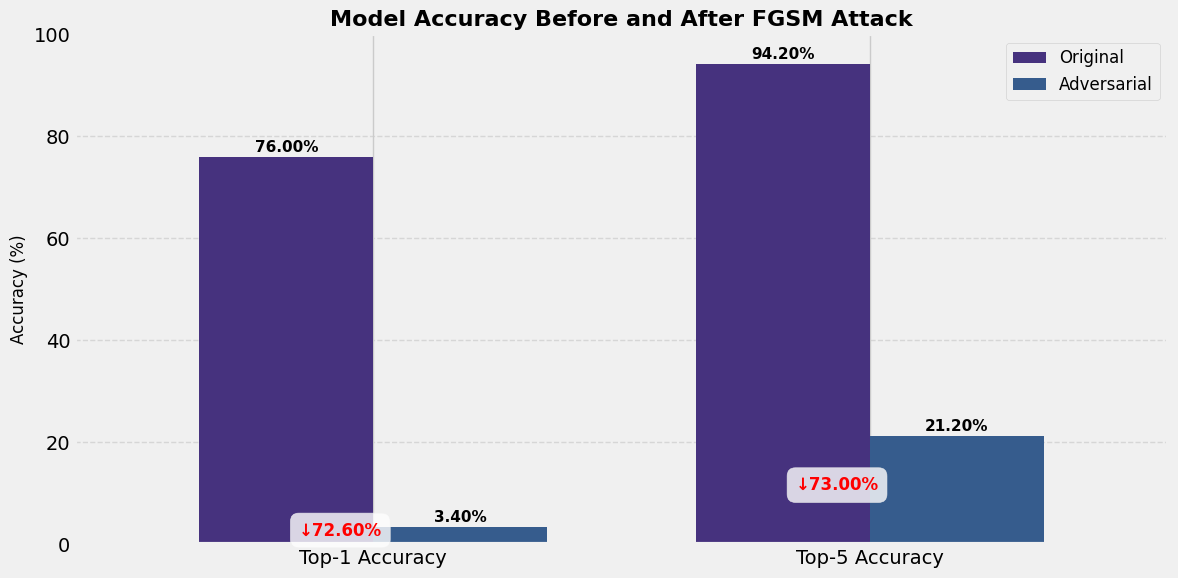


=== FGSM Attack Results (ε = 0.02) ===
Top-1 Accuracy: 3.40% (Drop: 72.60%)
Top-5 Accuracy: 21.20% (Drop: 73.00%)

Visualizing up to 5 successful adversarial examples...


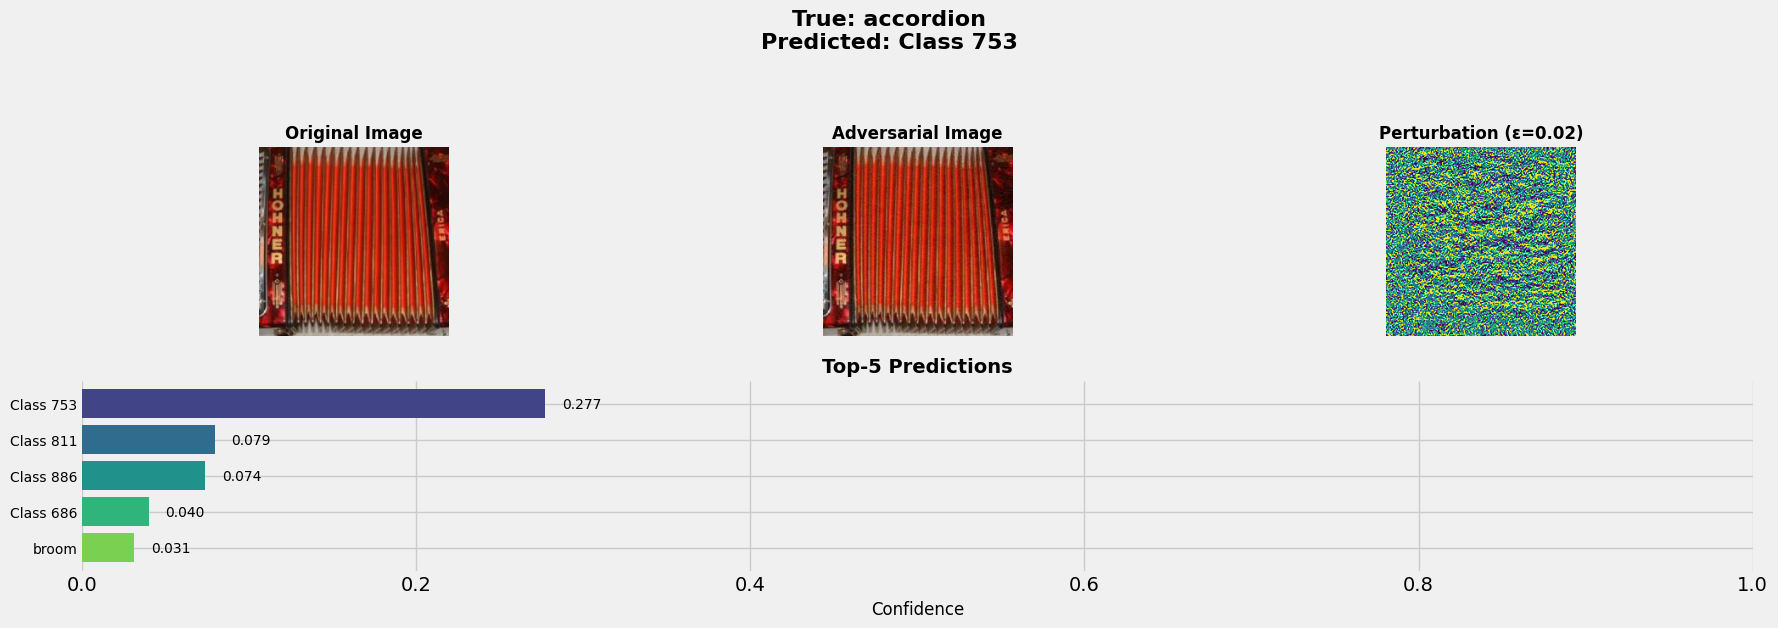

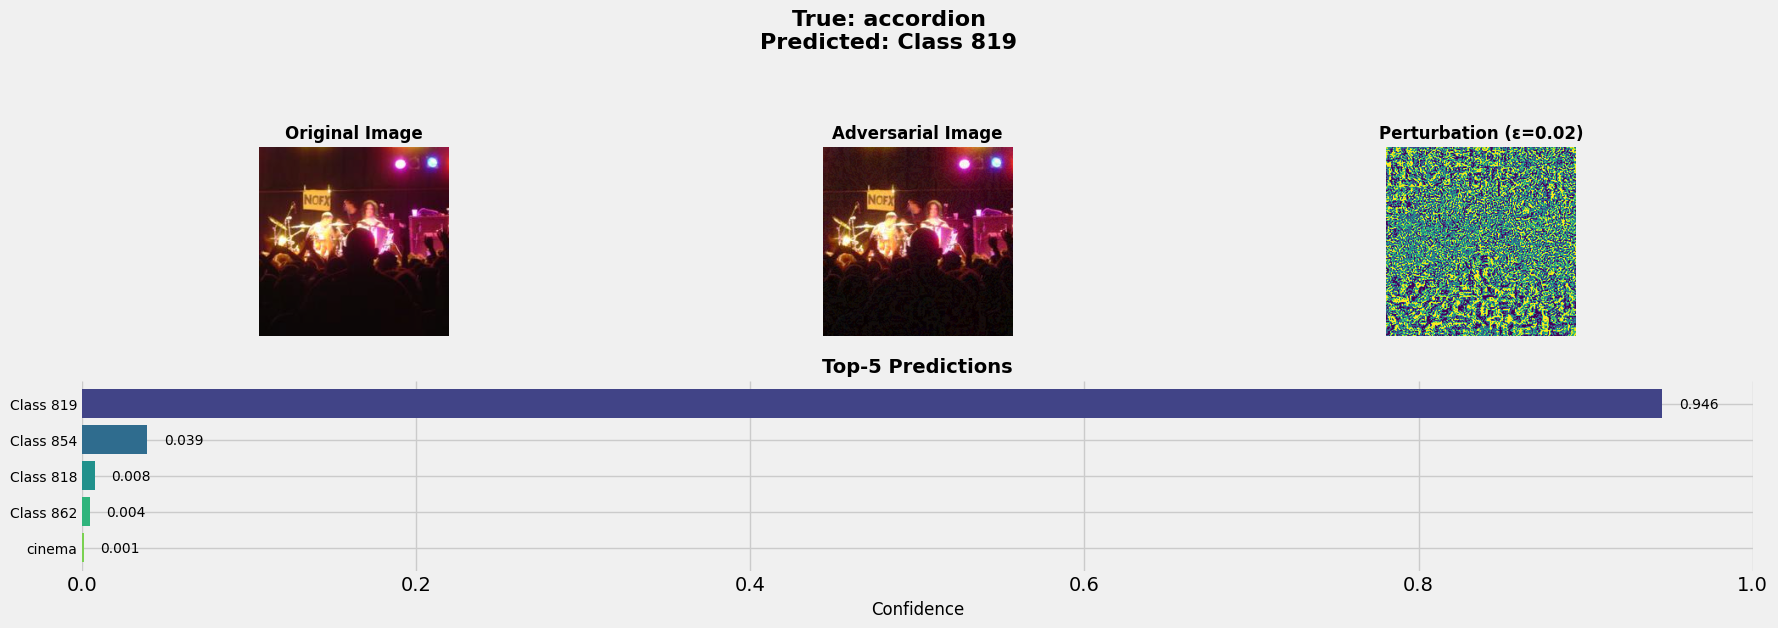

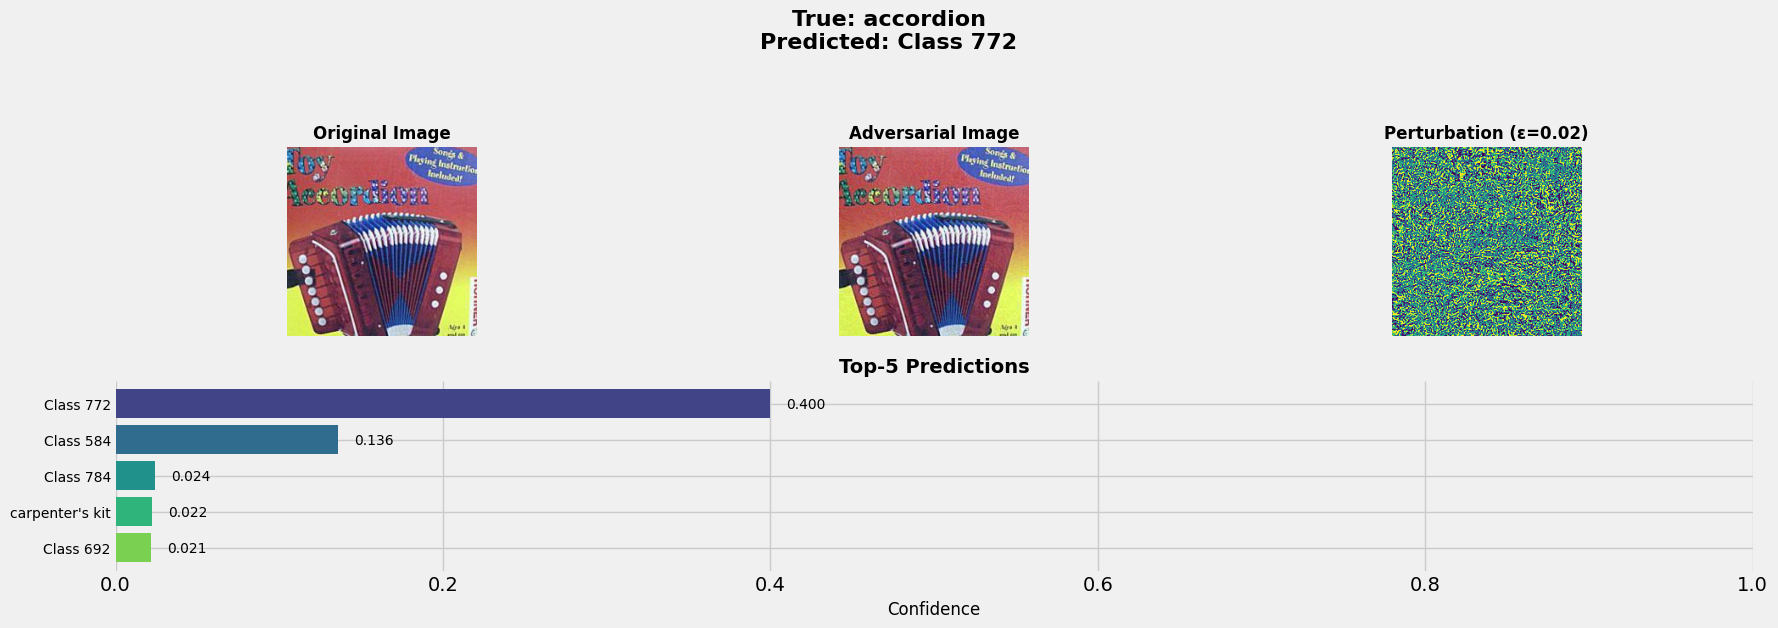

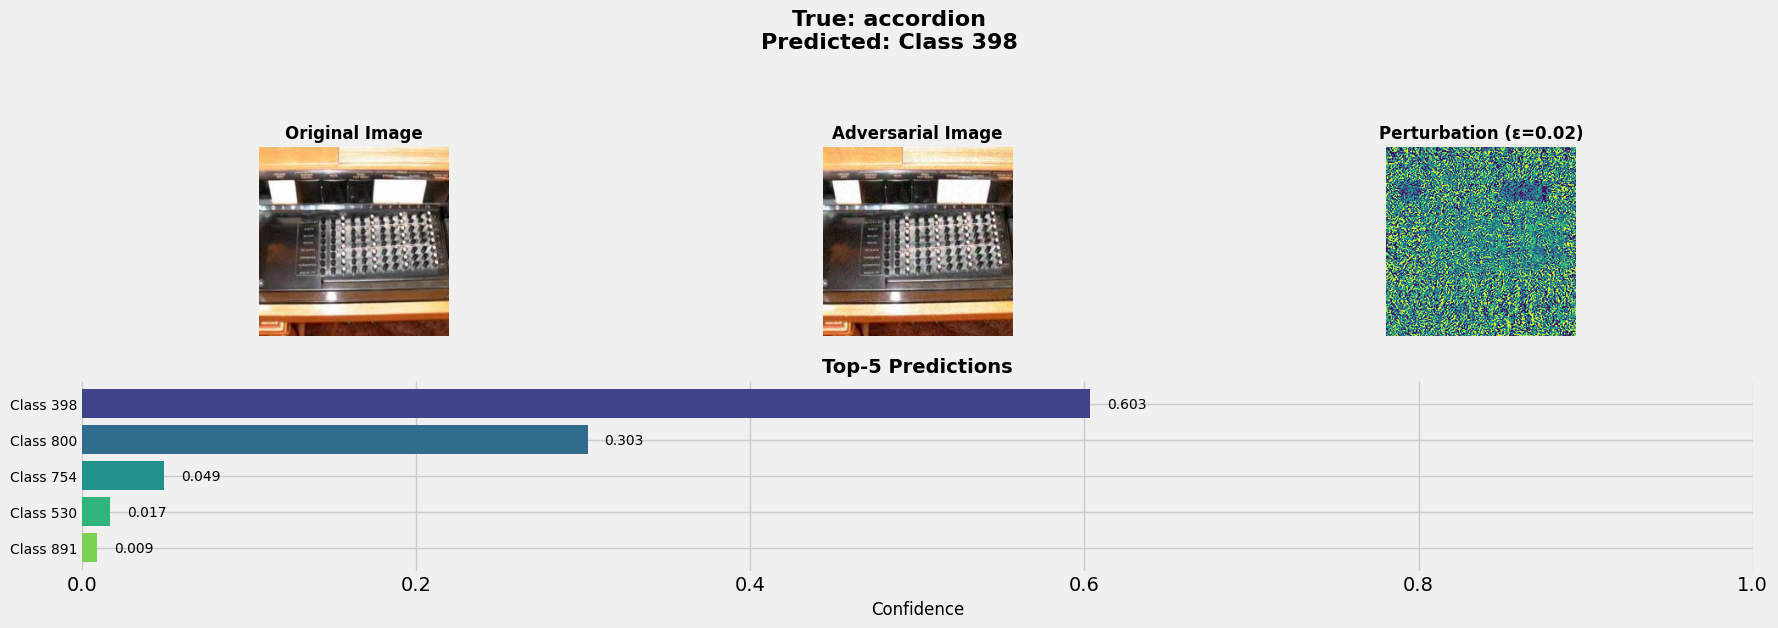

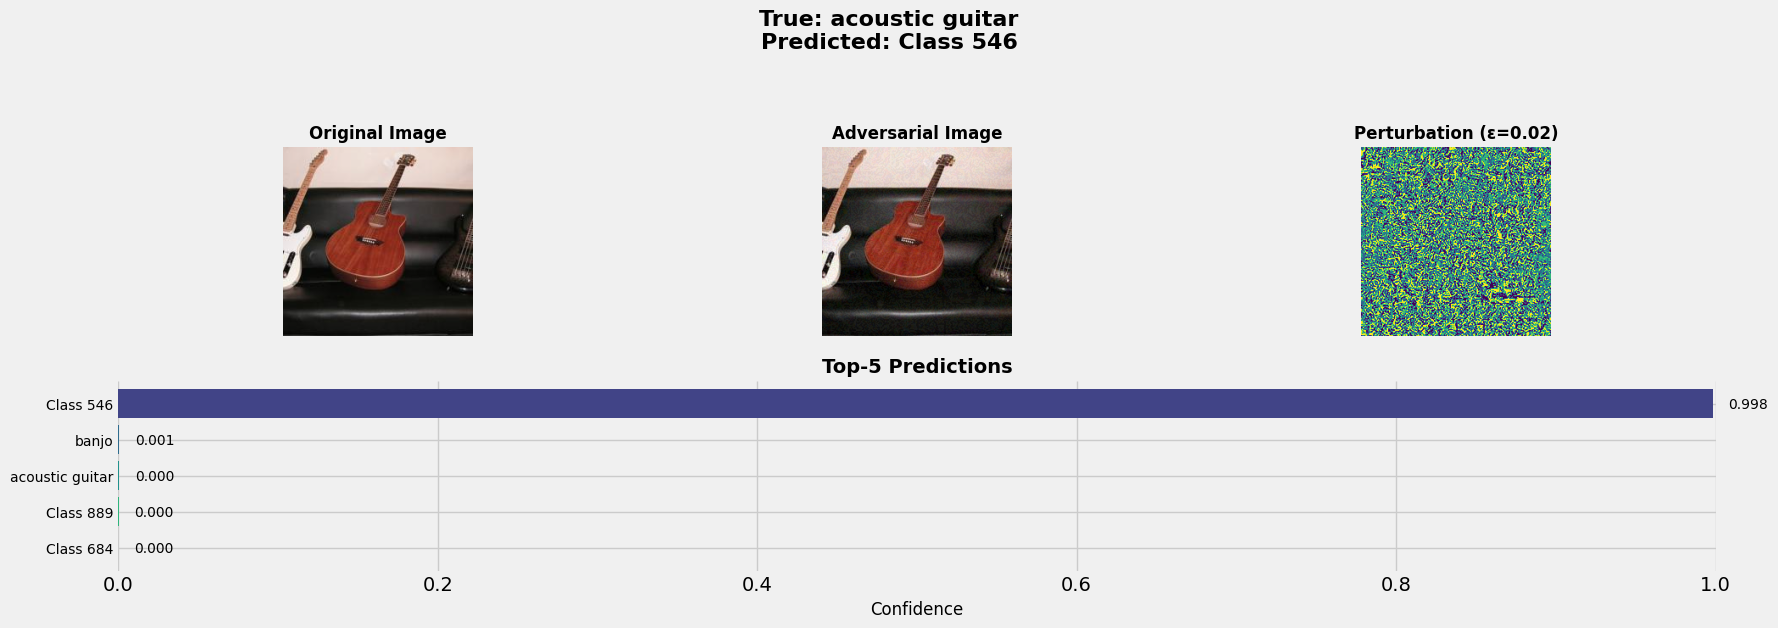

In [4]:
# Task 2: Generate and evaluate adversarial examples
print("\nTask 2: Generating FGSM adversarial examples...")
attacker = AdversarialAttacker(model, Config.DEVICE, Config.EPSILON)
adv_dataset = attacker.generate_fgsm_attack(test_loader, Config.ADV_OUTPUT_DIR)
adv_loader = DataLoader(adv_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

# Evaluate on adversarial examples
print("Evaluating model on adversarial examples...")
adv_results = evaluator.evaluate(adv_loader)

# Compare and visualize results
compare_results(clean_results, adv_results)

# Visualize selected adversarial examples
print(f"\nVisualizing up to {Config.MAX_EXAMPLES_TO_SHOW} successful adversarial examples...")
visualizer = Visualizer(model, data_manager, Config.DEVICE)


visualizer.visualize_adversarial_examples(test_loader, Config.EPSILON)


#### Findings:
- **Top-1 Accuracy dropped from 76.00% → 3.40%**
- **Top-5 Accuracy dropped from 94.20% → 21.20%**
- The perturbed images were **visually similar to the original test images**.


FGSM is very effective in degrading model performance. The attack required just a **single backward pass** and no model retraining, which makes it a powerful baseline for evaluating model robustness.


### Task 3: Improved Attack with PGD (Projected Gradient Descent)

In this task, we implemented a multi-step adversarial attack using **Projected Gradient Descent (PGD)**, an iterative improvement over FGSM. We set the attack parameters to:
- **ε = 0.02** (L∞ norm bound)
- **α = 0.005** (step size)
- **steps = 10**

Unlike FGSM’s one-shot perturbation, PGD performs multiple updates and projects the perturbed image back into the valid ε-ball after each step..




In [5]:
def unnormalize(tensor, mean=None, std=None):
    """Convert normalized image tensor to original scale [0,1]"""
    if mean is None:
        mean = Config.MEAN_NORMS
    if std is None:
        std = Config.STD_NORMS
        
    if tensor.dim() == 3:
        tensor = tensor.unsqueeze(0)
        
    mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).reshape(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

def renormalize(tensor, mean=None, std=None):
    """Convert image tensor to normalized scale"""
    if mean is None:
        mean = Config.MEAN_NORMS
    if std is None:
        std = Config.STD_NORMS
        
    if tensor.dim() == 3:
        tensor = tensor.unsqueeze(0)
        
    mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).reshape(1, 3, 1, 1).to(tensor.device)
    return (tensor - mean) / std

def calculate_topk_accuracy(output, target, topk=(1, 5)):
    """Compute the topk accuracy"""
    maxk = max(topk)
    batch_size = target.size(0)
    
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.item())
    return res

def generate_pgd_attack(model, images, labels, loss_fn, pgd_eps=0.02, pgd_alpha=0.005, pgd_steps=10, 
                      mean_norms=None, std_norms=None, device='cuda'):
    
    images_unnorm = unnormalize(images, mean_norms, std_norms).clone().detach()
    images_adv = images_unnorm.clone().detach().requires_grad_(True)
    
    for step in range(pgd_steps):
        model.zero_grad()
        # Renormalize adversarial images before feeding to model
        outputs = model(renormalize(images_adv, mean_norms, std_norms).float())
        loss = loss_fn(outputs, labels)
        loss.backward()
        grad = images_adv.grad.data
        
        # Update adversarial images with gradient sign
        images_adv = images_adv + pgd_alpha * grad.sign()
        
        # Project back to epsilon ball and valid pixel range
        images_adv = torch.max(torch.min(images_adv, images_unnorm + pgd_eps), images_unnorm - pgd_eps)
        images_adv = torch.clamp(images_adv, 0, 1).detach().requires_grad_(True)
    
    final_adv = renormalize(images_adv, mean_norms, std_norms).float()
    
    return final_adv, images_unnorm, images_adv.detach()

def generate_patch_attack(model, images, labels, loss_fn, patch_size=32, patch_eps=0.5, patch_alpha=0.12, 
                         pgd_steps=20, mean_norms=None, std_norms=None, device='cuda'):

    images_unnorm = unnormalize(images, mean_norms, std_norms).clone().detach()
    images_adv = images_unnorm.clone().detach().requires_grad_(True)
    
    # Get image dimensions and calculate patch center position
    B, C, H, W = images_unnorm.shape
    x_start = H // 2 - patch_size // 2
    y_start = W // 2 - patch_size // 2
    
    # Initialize momentum for MI-FGSM variant
    momentum = torch.zeros_like(images_adv).to(device)
    
    # Perform patch attack with momentum
    for step in range(pgd_steps):
        model.zero_grad()
        # Renormalize adversarial images before feeding to model
        outputs = model(renormalize(images_adv, mean_norms, std_norms).float())
        loss = loss_fn(outputs, labels)
        loss.backward()
        grad = images_adv.grad.data
        
        # Extract and normalize gradient for the patch region
        grad_patch = grad[:, :, x_start:x_start+patch_size, y_start:y_start+patch_size]
        grad_patch_norm = grad_patch / (grad_patch.abs().mean(dim=(1, 2, 3), keepdim=True) + 1e-8)
        
        # Update momentum
        momentum[:, :, x_start:x_start+patch_size, y_start:y_start+patch_size] = \
            0.9 * momentum[:, :, x_start:x_start+patch_size, y_start:y_start+patch_size] + grad_patch_norm
        
        # Apply perturbation only to the patch region
        perturb = torch.zeros_like(images_adv).to(device)
        perturb[:, :, x_start:x_start+patch_size, y_start:y_start+patch_size] = \
            patch_alpha * momentum[:, :, x_start:x_start+patch_size, y_start:y_start+patch_size].sign()
        
        # Update adversarial images
        images_adv = images_adv + perturb
        
        # Project back to epsilon ball and valid pixel range
        images_adv = torch.max(torch.min(images_adv, images_unnorm + patch_eps), images_unnorm - patch_eps)
        images_adv = torch.clamp(images_adv, 0, 1).detach().requires_grad_(True)
    
    final_adv = renormalize(images_adv, mean_norms, std_norms).float()
    
    return final_adv, images_unnorm, images_adv.detach()

def create_adversarial_dataset(model, data_loader, attack_fn, attack_params, save_dir=None, 
                              mean_norms=None, std_norms=None, device='cuda', loss_fn=None):

    if loss_fn is None:
        loss_fn = torch.nn.CrossEntropyLoss()
    
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    adversarial_images = []
    true_labels = []
    
    # Generate adversarial examples for each batch
    for i, (images, labels) in enumerate(tqdm(data_loader, desc="Generating adversarial examples")):
        images, labels = images.to(device), labels.to(device)
        
        # Generate adversarial examples
        adv_images, _, adv_unnorm = attack_fn(
            model=model,
            images=images,
            labels=labels,
            loss_fn=loss_fn,
            mean_norms=mean_norms,
            std_norms=std_norms,
            device=device,
            **attack_params
        )
        
        # Store adversarial examples and labels
        adversarial_images.append(adv_images.detach().cpu())
        true_labels.append(labels.detach().cpu())
        
        # Save adversarial images if directory is specified
        if save_dir is not None:
            for j in range(images.size(0)):
                img = adv_unnorm[j].detach().cpu()
                vutils.save_image(img, os.path.join(save_dir, f"img_{i*images.size(0) + j}.png"))
    
    # Create dataset and loader from adversarial examples
    adv_tensor = torch.cat(adversarial_images).float()
    label_tensor = torch.cat(true_labels)
    adv_dataset = TensorDataset(adv_tensor, label_tensor)
    adv_loader = DataLoader(adv_dataset, batch_size=data_loader.batch_size, shuffle=False)
    
    # Evaluate model on adversarial examples
    top1_correct = 0
    top5_correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(adv_loader, desc="Evaluating adversarial examples"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Calculate top-1 and top-5 accuracy
            correct_counts = calculate_topk_accuracy(outputs, labels, topk=(1, 5))
            top1_correct += correct_counts[0]
            top5_correct += correct_counts[1]
            total += labels.size(0)
    
    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    
    return adv_loader, top1_acc, top5_acc

def evaluate_task2(model, data_loader, attack_type, attack_params, save_dir=None, 
                  mean_norms=None, std_norms=None, device='cuda', 
                  baseline_top1=76.00, baseline_top5=94.20, loader_to_imagenet_map=None):
    import torch.nn as nn
    
    # Choose attack function based on attack type
    if attack_type.lower() == 'pgd':
        attack_fn = generate_pgd_attack
        attack_name = f"PGD Attack (ε = {attack_params.get('pgd_eps', 0.02)}, " \
                     f"α = {attack_params.get('pgd_alpha', 0.005)}, " \
                     f"steps = {attack_params.get('pgd_steps', 10)})"
    elif attack_type.lower() == 'patch':
        attack_fn = generate_patch_attack
        attack_name = f"Patch Attack (ε = {attack_params.get('patch_eps', 0.5)}, " \
                      f"α = {attack_params.get('patch_alpha', 0.12)}, " \
                      f"steps = {attack_params.get('pgd_steps', 20)}, " \
                      f"patch = {attack_params.get('patch_size', 32)}×{attack_params.get('patch_size', 32)})"
    else:
        raise ValueError(f"Unknown attack type: {attack_type}")
    
    # Loss function for the attack
    loss_fn = nn.CrossEntropyLoss()
    
    # Generate adversarial dataset and evaluate
    _, adv_top1, adv_top5 = create_adversarial_dataset(
        model=model,
        data_loader=data_loader,
        attack_fn=attack_fn,
        attack_params=attack_params,
        save_dir=save_dir,
        mean_norms=mean_norms,
        std_norms=std_norms,
        device=device,
        loss_fn=loss_fn
    )
    
    drop_top1 = baseline_top1 - adv_top1
    drop_top5 = baseline_top5 - adv_top5
    
    # Print results
    print(f"\n=== Task {3 if attack_type.lower() == 'pgd' else 4}: {attack_name} ===")
    print(f"Top-1 Accuracy : {adv_top1:.2f}%  (Drop Percentage: {drop_top1:.1f}%)")
    print(f"Top-5 Accuracy : {adv_top5:.2f}%  (Drop Percentage: {drop_top5:.1f}%)")
    print("=" * (len(attack_name) + 15) + "\n")
    
    return adv_top1, adv_top5, drop_top1, drop_top5

def visualize_adversarial_examples(model, data_loader, attack_type, attack_params,
                                  mean_norms, std_norms, device='cuda', max_to_show=5, class_names=None):

    # Choose attack function and parameters based on attack type
    if attack_type.lower() == 'pgd':
        attack_fn = generate_pgd_attack
        pgd_eps = attack_params.get('pgd_eps', 0.02)
        pgd_alpha = attack_params.get('pgd_alpha', 0.005)
        pgd_steps = attack_params.get('pgd_steps', 10)
    elif attack_type.lower() == 'patch':
        attack_fn = generate_patch_attack
        patch_size = attack_params.get('patch_size', 32)
        patch_eps = attack_params.get('patch_eps', 0.5)
        patch_alpha = attack_params.get('patch_alpha', 0.12)
        pgd_steps = attack_params.get('pgd_steps', 20)
    else:
        raise ValueError(f"Unknown attack type: {attack_type}")
    
    # Loss function for the attack
    loss_fn = nn.CrossEntropyLoss()
    
    shown = 0
    model.eval()
    
    for images, labels in data_loader:
        if shown >= max_to_show:
            break
            
        images, labels = images.to(device), labels.to(device)
        
        # Generate adversarial examples
        final_adv, images_unnorm, images_adv = attack_fn(
            model=model,
            images=images,
            labels=labels,
            loss_fn=loss_fn,
            mean_norms=mean_norms,
            std_norms=std_norms,
            device=device,
            **attack_params
        )
        
        # Get model predictions on adversarial examples
        with torch.no_grad():
            final_outputs = model(final_adv)
            preds = final_outputs.argmax(dim=1)
        
        # Visualize examples where the model prediction is incorrect
        for i in range(images.size(0)):
            if shown >= max_to_show:
                break
                
            if preds[i].item() != labels[i].item():
                # Original image
                orig_img = unnormalize(images[i].unsqueeze(0), mean_norms, std_norms).squeeze(0).detach().cpu()
                # Adversarial image
                adv_img = images_adv[i].detach().cpu()
                # Perturbation (noise)
                noise = (adv_img - orig_img).detach().cpu()
                noise_norm = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)
                
                # Get top-5 predictions and probabilities
                probs = F.softmax(final_outputs[i], dim=0)
                top5_vals, top5_idxs = torch.topk(probs, 5)
                top5_probs = top5_vals.cpu().numpy()
                
                if class_names is not None:
                    top5_labels = [
                        class_names[idx.item() - 401] if 401 <= idx.item() <= 500 else f"Class {idx.item()}"
                        for idx in top5_idxs
                    ]
                    true_id = labels[i].item()
                    pred_id = preds[i].item()
                    true_label = class_names[true_id - 401] if 401 <= true_id <= 500 else f"Class {true_id}"
                    pred_label = class_names[pred_id - 401] if 401 <= pred_id <= 500 else f"Class {pred_id}"
                else:
                    top5_labels = [f"Class {idx.item()}" for idx in top5_idxs]
                    true_label = f"Class {labels[i].item()}"
                    pred_label = f"Class {preds[i].item()}"
                
                # Create visualization figure
                if attack_type.lower() == 'pgd':
                    # PGD attack visualization
                    fig = plt.figure(figsize=(18, 5))
                    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1.3])
                    plt.subplots_adjust(wspace=0.7)
                    
                    ax0 = plt.subplot(gs[0])
                    ax0.imshow(orig_img.permute(1, 2, 0).numpy().clip(0, 1))
                    ax0.set_title("Original", fontsize=12, fontweight='bold')
                    ax0.axis('off')
                    
                    ax1 = plt.subplot(gs[1])
                    ax1.imshow(adv_img.permute(1, 2, 0).numpy().clip(0, 1))
                    ax1.set_title("PGD Adversarial", fontsize=12, fontweight='bold')
                    ax1.axis('off')
                    
                    ax2 = plt.subplot(gs[2])
                    ax2.imshow(noise_norm.permute(1, 2, 0).numpy(), cmap='gray')
                    ax2.set_title("Perturbation", fontsize=12, fontweight='bold')
                    ax2.axis('off')
                    
                    ax3 = plt.subplot(gs[3])
                    ax3.barh(range(5), top5_probs[::-1], color='royalblue')
                    ax3.set_yticks(range(5))
                    ax3.set_yticklabels(top5_labels[::-1], fontsize=10)
                    ax3.set_xlim(0, 1.0)
                    ax3.set_title("Top-5 Predictions", fontsize=12, fontweight='bold')
                    ax3.set_xlabel("Confidence", fontsize=9)
                    ax3.invert_yaxis()
                    for spine in ax3.spines.values():
                        spine.set_visible(False)
                    
                    fig.suptitle(f"True: {true_label}   |   Predicted: {pred_label}", 
                                fontsize=15, fontweight='bold', y=1.08)
                
                elif attack_type.lower() == 'patch':
                    # Patch attack visualization - adjust visualization for patch
                    fig = plt.figure(figsize=(14, 3))
                    plt.suptitle(f"True: {true_label} → Predicted: {pred_label}", fontsize=12, weight='bold')
                    
                    ax0 = plt.subplot(1, 4, 1)
                    ax0.imshow(orig_img.permute(1, 2, 0).numpy().clip(0, 1))
                    ax0.set_title("Original")
                    ax0.axis('off')
                    
                    ax1 = plt.subplot(1, 4, 2)
                    ax1.imshow(adv_img.permute(1, 2, 0).numpy().clip(0, 1))
                    ax1.set_title("Patch Adversarial")
                    ax1.axis('off')
                    
                    # Highlight the patch area
                    if 'patch_size' in attack_params:
                        patch_size = attack_params['patch_size']
                        # orig_img and noise_norm are H×W×3 NumPy arrays
                        H, W, _ = orig_img.shape
                        x_start = H // 2 - patch_size // 2
                        y_start = W // 2 - patch_size // 2
            
                        noise_np  = noise_norm.cpu().numpy()   # shape (H,W,3)
                        noise_vis = noise_np.copy()
                        noise_vis[x_start:x_start+patch_size,
                                  y_start:y_start+patch_size,
                                  :] = noise_norm[x_start:x_start+patch_size,
                                                  y_start:y_start+patch_size,
                                                  :]
                    
                    ax2 = plt.subplot(1, 4, 3)
                    ax2.imshow(noise_vis)
                    ax2.set_title("Perturbation (Noise)")
                    ax2.axis('off')
                    
                    ax3 = plt.subplot(1, 4, 4)
                    ax3.barh(top5_labels[::-1], top5_probs.cpu().numpy()[::-1], color="royalblue")
                    ax3.set_xlim(0, 1)
                    ax3.set_title("Top-5 Predictions")
                    ax3.set_xlabel("Confidence")
                
                plt.tight_layout()
                plt.show()
                
                shown += 1

In [6]:
import matplotlib.gridspec as gridspec
# Task 3: PGD Attack Evaluation ---
pgd_params = {
    'pgd_eps': 0.02,
    'pgd_alpha': 0.005,
    'pgd_steps': 10
}
adv_dir_pgd = "./Adversarial_Test_Set_2"
pgd_top1, pgd_top5, pgd_drop1, pgd_drop5 = evaluate_task2(
    model=model, 
    data_loader=test_loader, 
    attack_type='pgd', 
    attack_params=pgd_params,
    save_dir=adv_dir_pgd,
    mean_norms=Config.MEAN_NORMS,
    std_norms=Config.STD_NORMS,
    device=Config.DEVICE,
    baseline_top1=clean_results['top1'], 
    baseline_top5=clean_results['top5']
)




Generating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]


=== Task 3: PGD Attack (ε = 0.02, α = 0.005, steps = 10) ===
Top-1 Accuracy : 0.00%  (Drop Percentage: 76.0%)
Top-5 Accuracy : 1.00%  (Drop Percentage: 93.2%)



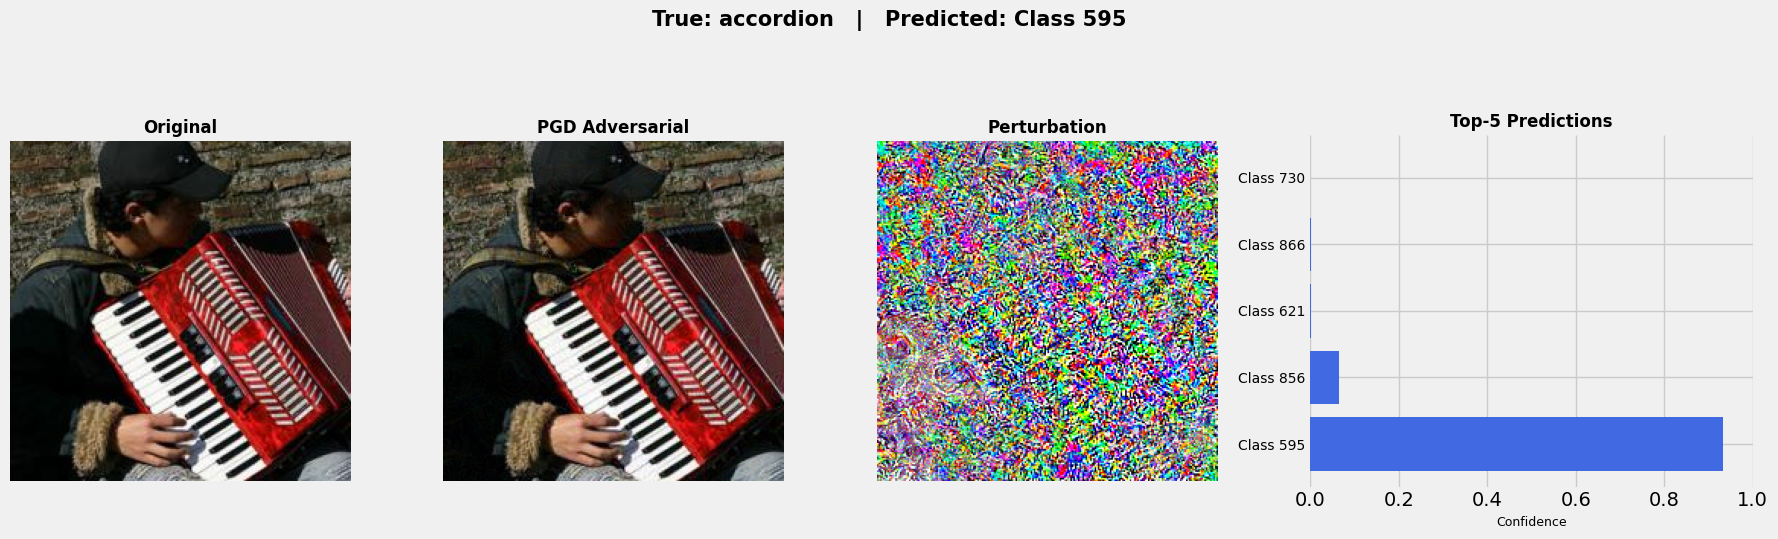

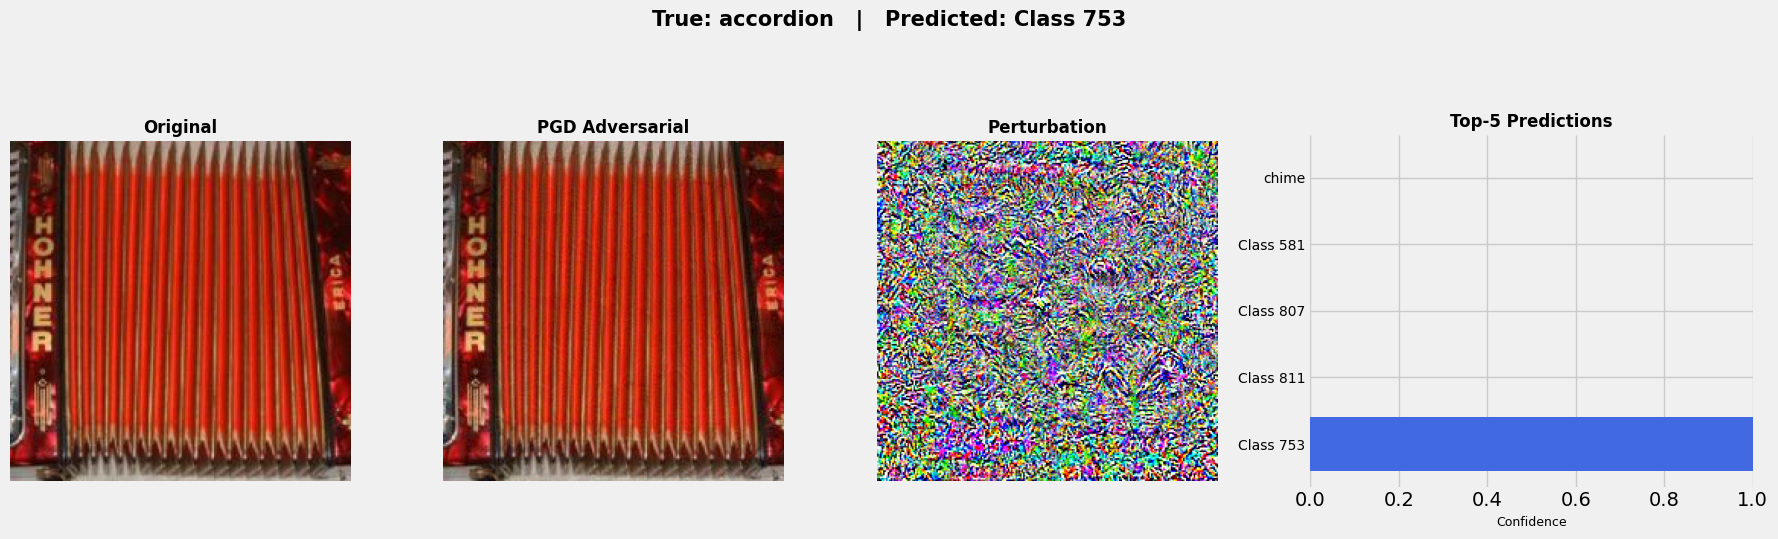

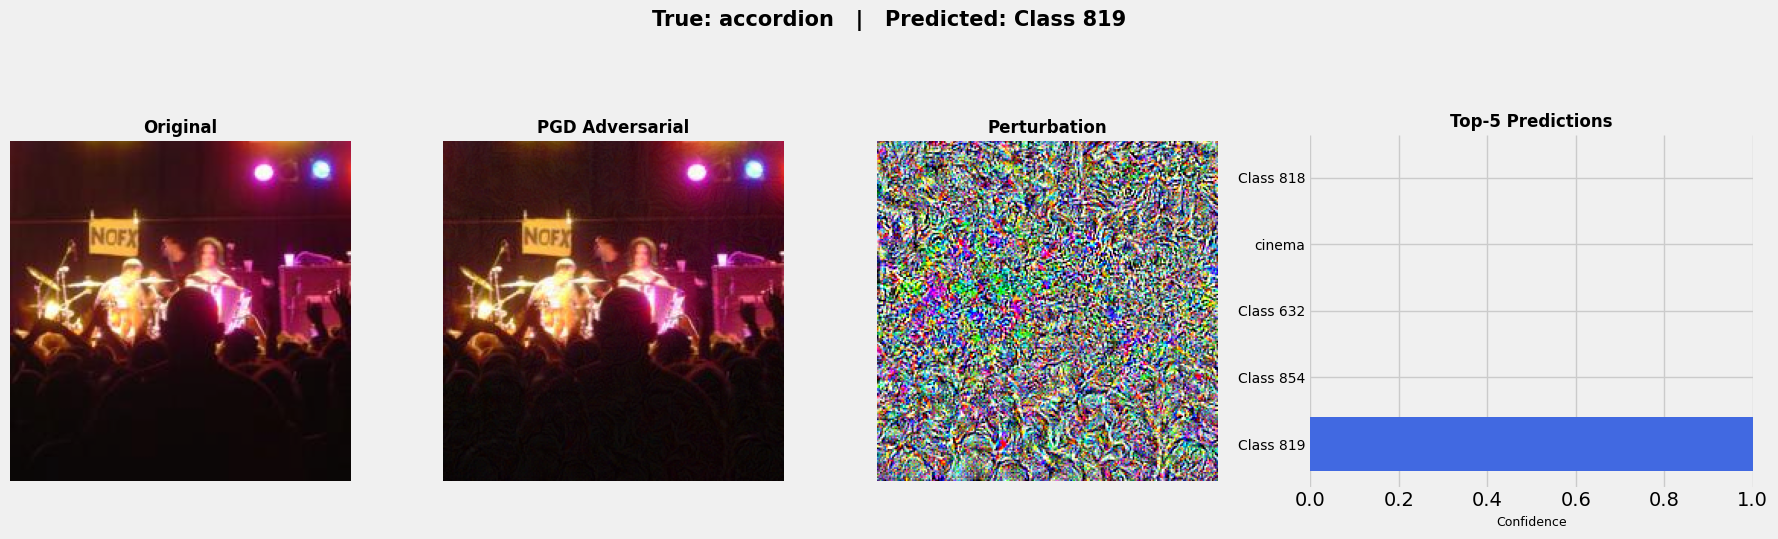

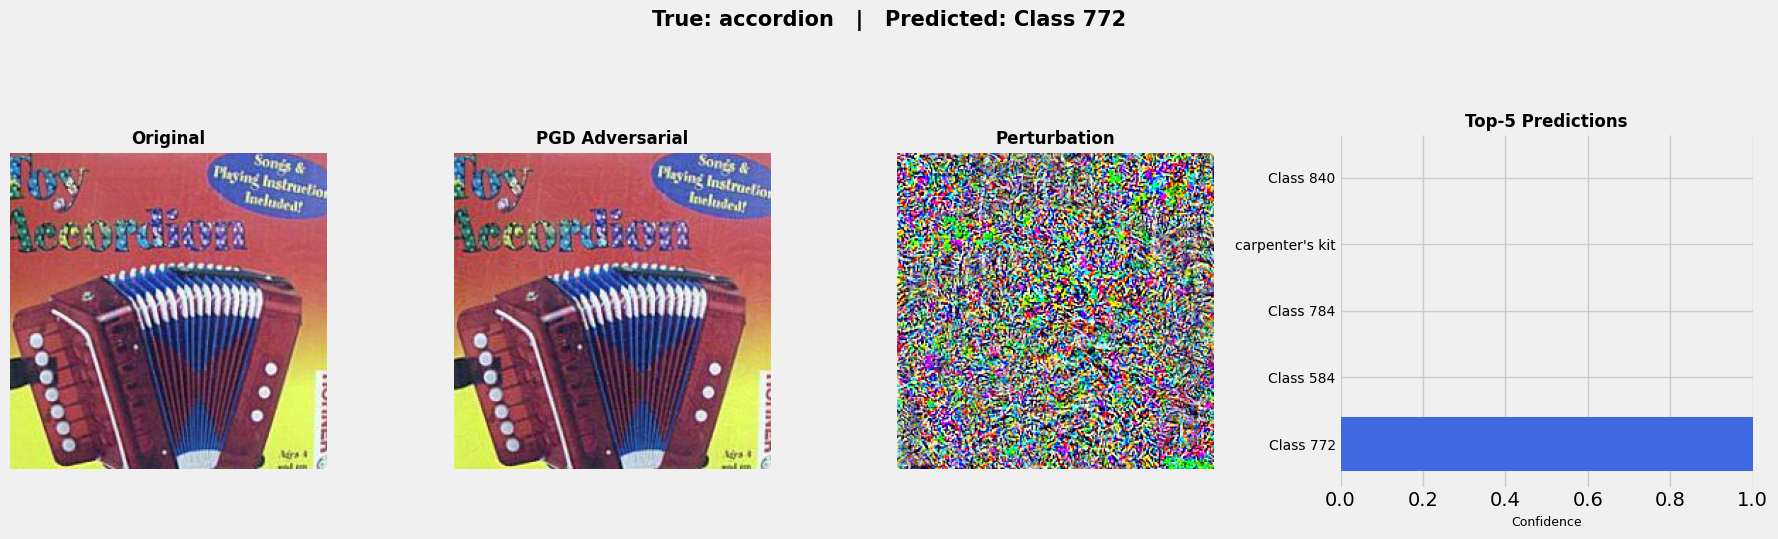

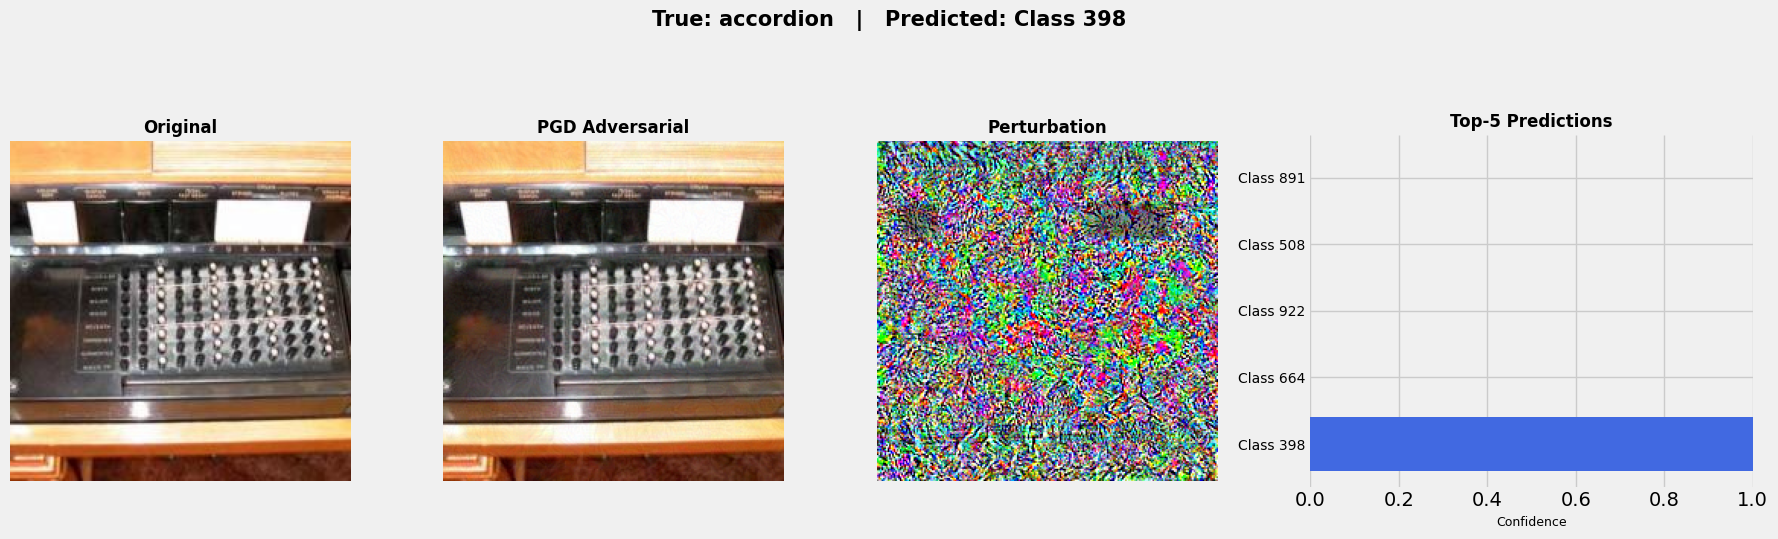

In [7]:
# Visualize some examples for PGD attack
visualize_adversarial_examples(
    model=model,
    data_loader=test_loader,
    attack_type='pgd',
    attack_params=pgd_params,
    mean_norms=Config.MEAN_NORMS,
    std_norms=Config.STD_NORMS,
    device=Config.DEVICE,
    max_to_show=5,
    class_names=data_manager.class_names
)


#### Findings:
- **Top-1 Accuracy dropped from 76.00% → 0.00%**
- **Top-5 Accuracy dropped from 94.20% → 1.00%**
- The generated images were visually indistinguishable from the original samples, confirming that the perturbations were both subtle and effective.

PGD dramatically outperformed FGSM under the ε=0.02 L∞ constraint, highlighting how multi-step optimization can exploit a model’s vulnerabilities more effectively. This shows how brittle deep models can be, even small, bounded iterative noise can reduce performance to near-random guessing.


### Task 4: Localized Patch Attack (L₀ Constraint)

In this task, we implemented a **patch-based adversarial attack** — a localized L₀-style perturbation restricted to a fixed 32×32 region of each image. This simulates a more constrained adversarial scenario where only a small portion of the image can be altered. 

We used a variant of **MI-FGSM (momentum-based iterative attack)**, localized to a central patch, with the following parameters:
- **Patch size**: 32×32 pixels
- **ε = 0.5** (maximum perturbation per pixel within patch)
- **α = 0.12** (step size)
- **Steps = 20**

Generating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]


=== Task 4: Patch Attack (ε = 0.5, α = 0.12, steps = 20, patch = 32×32) ===
Top-1 Accuracy : 4.40%  (Drop Percentage: 71.6%)
Top-5 Accuracy : 35.60%  (Drop Percentage: 58.6%)

Generating patch attacks with patch size=32, eps=0.5, alpha=0.12, steps=20


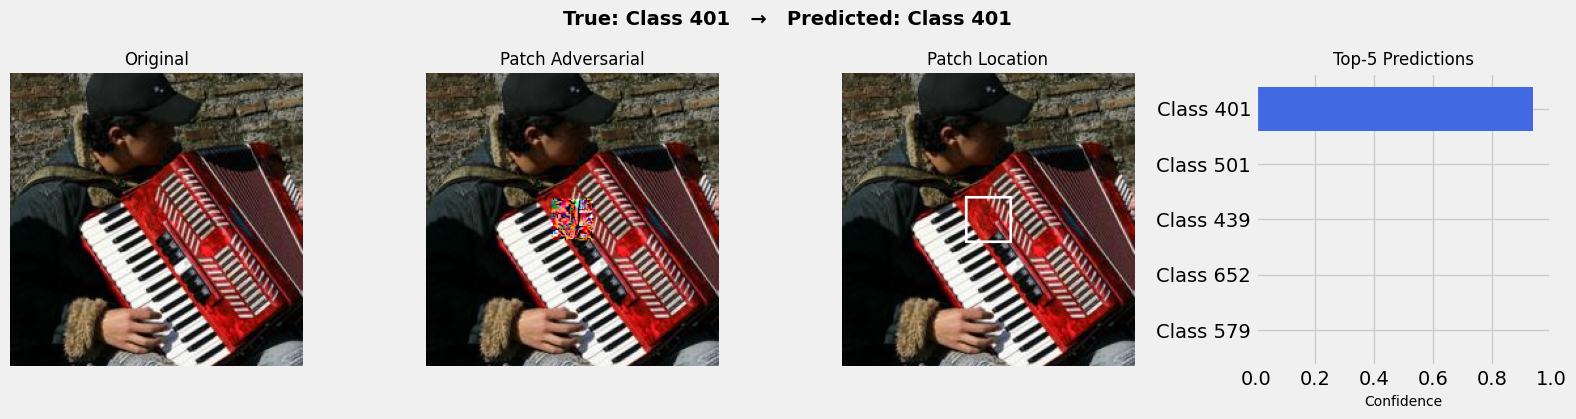

Showing example 1/5: Failed attack


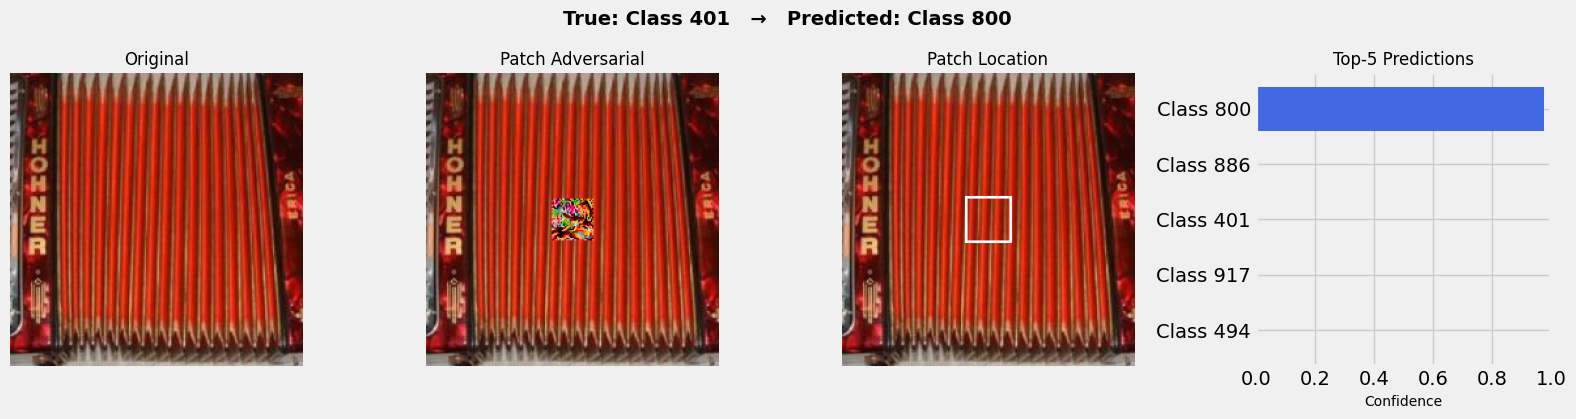

Showing example 2/5: Successful attack


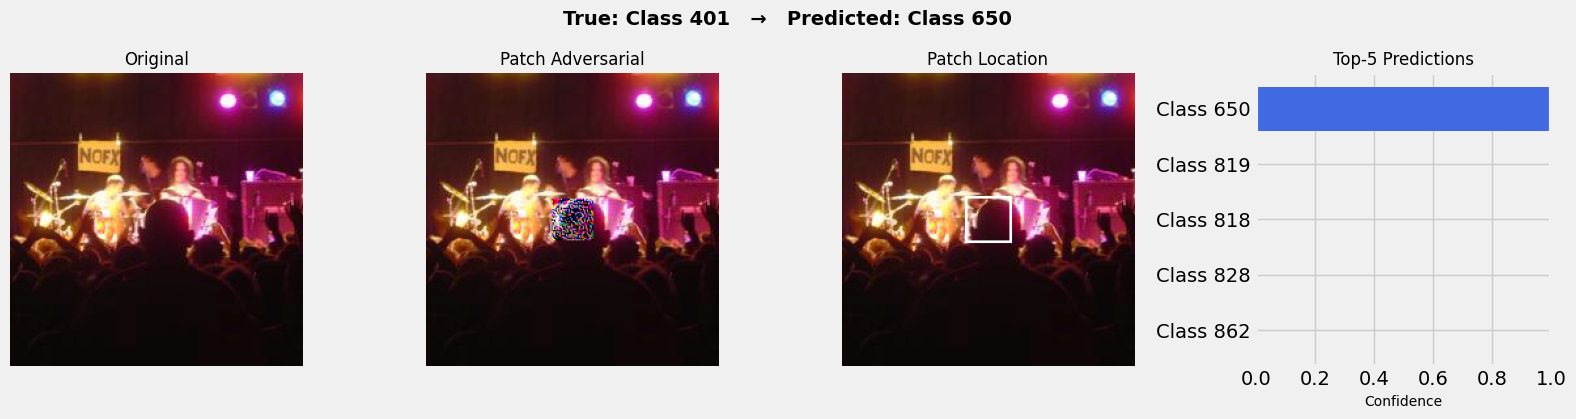

Showing example 3/5: Successful attack


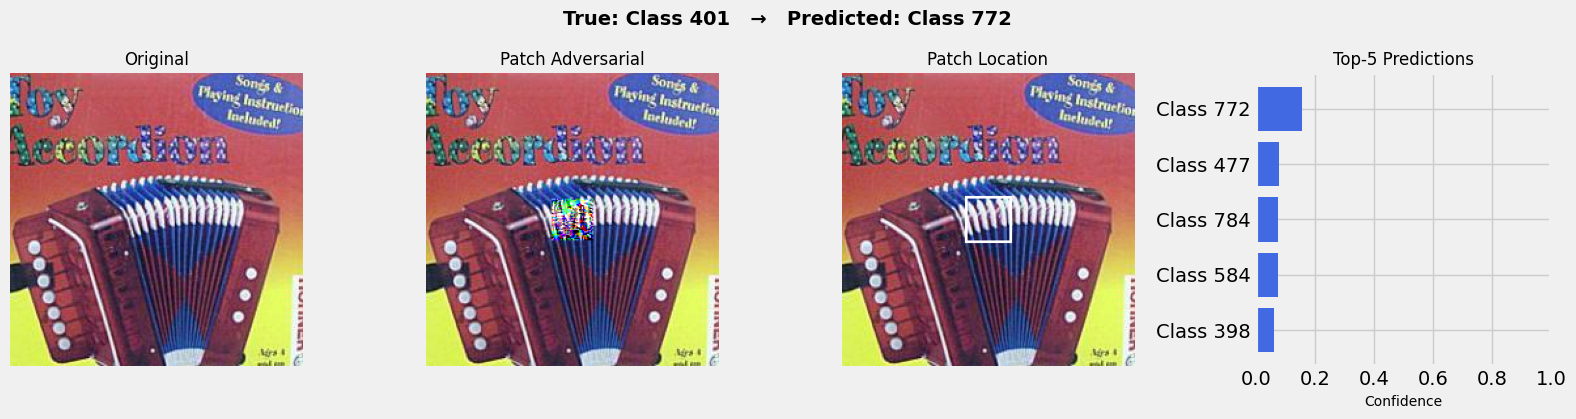

Showing example 4/5: Successful attack


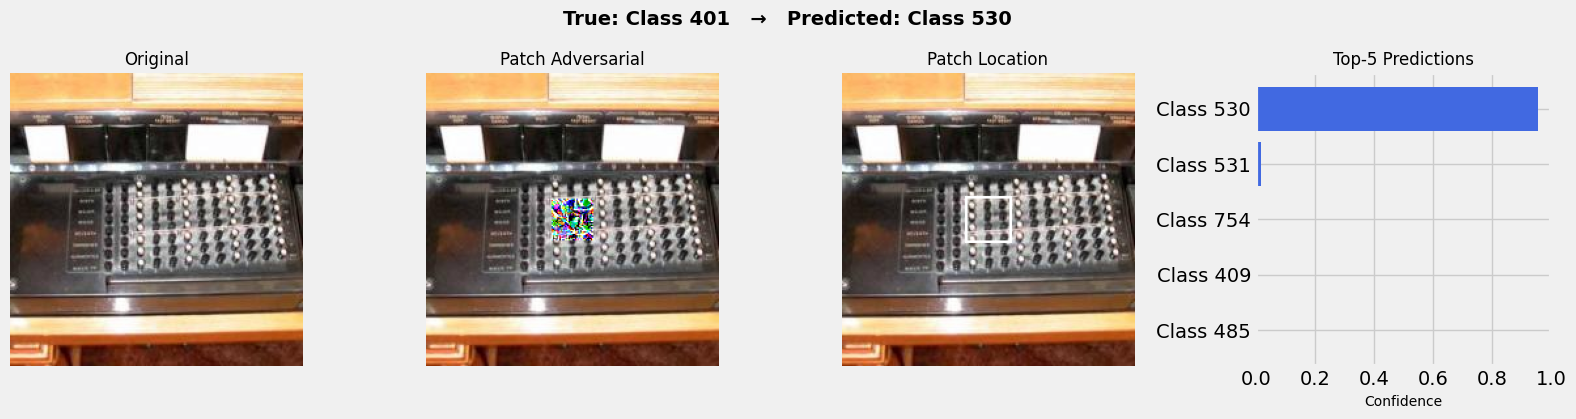

Showing example 5/5: Successful attack


In [8]:
# Task 4: Patch Attack Evaluation ---
patch_params = {
    'patch_size': 32,
    'patch_eps': 0.5,
    'patch_alpha': 0.12,
    'pgd_steps': 20
}
adv_dir_patch = "./Adversarial_Test_Set_3"
patch_top1, patch_top5, patch_drop1, patch_drop5 = evaluate_task2(
    model=model, 
    data_loader=test_loader, 
    attack_type='patch', 
    attack_params=patch_params,
    save_dir=adv_dir_patch,
    mean_norms=Config.MEAN_NORMS, 
    std_norms=Config.STD_NORMS, 
    device=Config.DEVICE,
    baseline_top1=clean_results['top1'], 
    baseline_top5=clean_results['top5']
)
def visualize_patch_attack(model, data_loader, patch_params, mean_norms, std_norms, 
                          device='cuda', max_to_show=5, class_names=None):
    import torch.nn as nn
    
    patch_size = patch_params.get('patch_size', 32)
    patch_eps = patch_params.get('patch_eps', 0.5)
    patch_alpha = patch_params.get('patch_alpha', 0.12)
    pgd_steps = patch_params.get('pgd_steps', 20)
    
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    shown = 0
    
    print(f"Generating patch attacks with patch size={patch_size}, eps={patch_eps}, alpha={patch_alpha}, steps={pgd_steps}")
    
    for images, labels in data_loader:
        if shown >= max_to_show:
            break
            
        images, labels = images.to(device), labels.to(device)
        
        # Generate patch attack
        final_adv, images_unnorm, images_adv = generate_patch_attack(
            model=model,
            images=images,
            labels=labels,
            loss_fn=loss_fn,
            patch_size=patch_size,
            patch_eps=patch_eps,
            patch_alpha=patch_alpha,
            pgd_steps=pgd_steps,
            mean_norms=mean_norms,
            std_norms=std_norms,
            device=device
        )
        
        # Get model predictions on adversarial examples
        with torch.no_grad():
            final_outputs = model(final_adv)
            preds = final_outputs.argmax(dim=1)
        
        # Visualize examples where the model prediction is incorrect
        for i in range(images.size(0)):
            if shown >= max_to_show:
                break
            
            # Original image
            orig_img = images_unnorm[i].detach().cpu()
            
            # Adversarial image
            adv_img = images_adv[i].detach().cpu()
            
            # Perturbation (noise)
            noise = (adv_img - orig_img).detach().cpu()
            noise_norm = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)
            
            # Get top-5 predictions and probabilities
            probs = F.softmax(final_outputs[i], dim=0)
            top5_vals, top5_idxs = torch.topk(probs, 5)
            top5_probs = top5_vals.cpu().numpy()
            
            true_id = labels[i].item()
            pred_id = preds[i].item()
            
            if class_names is not None:
                try:
                    top5_labels = [class_names[idx.item()] for idx in top5_idxs]
                    true_label = class_names[true_id]
                    pred_label = class_names[pred_id]
                except IndexError:
                    top5_labels = [f"Class {idx.item()}" for idx in top5_idxs]
                    true_label = f"Class {true_id}"
                    pred_label = f"Class {pred_id}"
            else:
                top5_labels = [f"Class {idx.item()}" for idx in top5_idxs]
                true_label = f"Class {true_id}"
                pred_label = f"Class {pred_id}"
            
            fig = plt.figure(figsize=(16, 4))
            
            # Original image
            ax0 = plt.subplot(1, 4, 1)
            ax0.imshow(orig_img.permute(1, 2, 0).numpy().clip(0, 1))
            ax0.set_title("Original", fontsize=12)
            ax0.axis('off')
            
            # Adversarial image
            ax1 = plt.subplot(1, 4, 2)
            ax1.imshow(adv_img.permute(1, 2, 0).numpy().clip(0, 1))
            ax1.set_title("Patch Adversarial", fontsize=12)
            ax1.axis('off')
            
            B, C, H, W = orig_img.unsqueeze(0).shape
            x_start = H // 2 - patch_size // 2
            y_start = W // 2 - patch_size // 2
            
            highlighted_patch = orig_img.clone()
            border_size = 2
            for c in range(3):
                highlighted_patch[c, x_start-border_size:x_start, y_start-border_size:y_start+patch_size+border_size] = 1.0
                highlighted_patch[c, x_start+patch_size:x_start+patch_size+border_size, y_start-border_size:y_start+patch_size+border_size] = 1.0
                highlighted_patch[c, x_start-border_size:x_start+patch_size+border_size, y_start-border_size:y_start] = 1.0
                highlighted_patch[c, x_start-border_size:x_start+patch_size+border_size, y_start+patch_size:y_start+patch_size+border_size] = 1.0
            
            # Visualization of the patch location
            ax2 = plt.subplot(1, 4, 3)
            ax2.imshow(highlighted_patch.permute(1, 2, 0).numpy().clip(0, 1))
            ax2.set_title("Patch Location", fontsize=12)
            ax2.axis('off')
            
            # Top-5 predictions
            ax3 = plt.subplot(1, 4, 4)
            y_pos = range(len(top5_labels))
            ax3.barh(y_pos, top5_probs, color='royalblue')
            ax3.set_yticks(y_pos)
            ax3.set_yticklabels(top5_labels)
            ax3.set_xlim(0, 1.0)
            ax3.set_title("Top-5 Predictions", fontsize=12)
            ax3.set_xlabel("Confidence", fontsize=10)
            ax3.invert_yaxis()
            
            plt.tight_layout()
            fig.suptitle(f"True: {true_label}   →   Predicted: {pred_label}", 
                        fontsize=14, fontweight='bold', y=1.05)
            plt.show()
            
            shown += 1
            print(f"Showing example {shown}/{max_to_show}: {'Successful attack' if preds[i].item() != labels[i].item() else 'Failed attack'}")

visualize_patch_attack(
    model=model,
    data_loader=test_loader,
    patch_params=patch_params,
    mean_norms=Config.MEAN_NORMS,
    std_norms=Config.STD_NORMS,
    device=Config.DEVICE,
    max_to_show=5,
    class_names=data_manager.class_names
)

#### Findings:
- **Top-1 Accuracy dropped from 76.00% → 4.40%**
- **Top-5 Accuracy dropped from 94.20% → 35.60%**
- The attack was highly effective despite affecting only a small region of each image.

The patch attack demonstrates that even small, localized perturbations can degrade model performance dramatically,  especially when optimized using momentum or multiple steps. Limiting the perturbation to a region adds realism while still exposing the vulnerability of deep models to targeted input manipulation.


### Task 5: Transferability of Adversarial Attacks to DenseNet-121

In this task, we evaluated how adversarial examples crafted for **ResNet-34** transfer to a different model — **DenseNet-121**, pre-trained on the same ImageNet-1K dataset. This tests the **transferability** property of adversarial attacks: whether perturbations that fool one model can also fool another, without re-optimizing for it.

We reused the previously generated adversarial datasets:
- **Adversarial Test Set 1** (FGSM)
- **Adversarial Test Set 2** (PGD)
- **Adversarial Test Set 3** (Patch)

We then measured **Top-1** and **Top-5 accuracies** on DenseNet-121 using all 4 datasets (including the clean test set) to understand performance degradation.


In [9]:
def evaluate_task5_transferability(source_model, target_model, data_loader, 
                            fgsm_loader, pgd_loader, patch_loader, 
                            mean_norms=None, std_norms=None, device='cuda'):
    import torch
    from tqdm import tqdm
    from tabulate import tabulate
    
    source_model.eval()
    target_model.eval()
    
    def evaluate_accuracy(dataloader):
        top1_correct = 0
        top5_correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc="Evaluating"):
                images, labels = images.to(device), labels.to(device)
                outputs = target_model(images)
                # Calculate top-1 and top-5 accuracy
                top1, top5 = calculate_topk_accuracy(outputs, labels, topk=(1, 5))
                top1_correct += top1
                top5_correct += top5
                total += labels.size(0)
        
        top1_acc = 100 * top1_correct / total
        top5_acc = 100 * top5_correct / total
        return top1_acc, top5_acc
    
    print("\nEvaluating DenseNet-121 on clean data...")
    clean_top1, clean_top5 = evaluate_accuracy(data_loader)

    print("Evaluating DenseNet-121 on FGSM adversarial examples...")
    fgsm_top1, fgsm_top5 = evaluate_accuracy(fgsm_loader)
    
    print("Evaluating DenseNet-121 on PGD adversarial examples...")
    pgd_top1, pgd_top5 = evaluate_accuracy(pgd_loader)
    
    print("Evaluating DenseNet-121 on Patch adversarial examples...")
    patch_top1, patch_top5 = evaluate_accuracy(patch_loader)
    
    # Calculate drop percentages
    fgsm_drop1 = clean_top1 - fgsm_top1
    fgsm_drop5 = clean_top5 - fgsm_top5
    
    pgd_drop1 = clean_top1 - pgd_top1
    pgd_drop5 = clean_top5 - pgd_top5
    
    patch_drop1 = clean_top1 - patch_top1
    patch_drop5 = clean_top5 - patch_top5
    
    # Prepare summary
    summary = [
        ["Clean", clean_top1, clean_top5, 0.0, 0.0],
        ["FGSM", fgsm_top1, fgsm_top5, fgsm_drop1, fgsm_drop5],
        ["PGD", pgd_top1, pgd_top5, pgd_drop1, pgd_drop5],
        ["Patch", patch_top1, patch_top5, patch_drop1, patch_drop5],
    ]
    
    headers = ["Dataset", "Top-1 Accuracy (%)", "Top-5 Accuracy (%)", "Top-1 Drop (%)", "Top-5 Drop (%)"]
    
    # Print results
    print("\n=== Task 5: Transferability to DenseNet-121 ===")
    print(tabulate(summary, headers=headers, tablefmt="github"))
    
    return {
        "clean": {"top1": clean_top1, "top5": clean_top5},
        "fgsm": {"top1": fgsm_top1, "top5": fgsm_top5, "drop1": fgsm_drop1, "drop5": fgsm_drop5},
        "pgd": {"top1": pgd_top1, "top5": pgd_top5, "drop1": pgd_drop1, "drop5": pgd_drop5},
        "patch": {"top1": patch_top1, "top5": patch_top5, "drop1": patch_drop1, "drop5": patch_drop5}
    }

def run_task5(source_model, data_loader, fgsm_loader, mean_norms=None, std_norms=None, device='cuda'):
    import torch
    import torchvision.models as models
    from torch.utils.data import DataLoader, TensorDataset
    
    print("Loading DenseNet-121 model...")
    densenet = models.densenet121(weights='IMAGENET1K_V1').to(device)
    densenet.eval()

    # Generate PGD adversarial examples
    pgd_params = {
        'pgd_eps': 0.02,
        'pgd_alpha': 0.005,
        'pgd_steps': 10
    }
    
    print("Generating PGD adversarial examples for transferability test...")
    pgd_adv, _, _ = create_adversarial_dataset(
        model=source_model,
        data_loader=data_loader,
        attack_fn=generate_pgd_attack,
        attack_params=pgd_params,
        mean_norms=mean_norms,
        std_norms=std_norms,
        device=device
    )
    
    # Generate Patch adversarial examples
    patch_params = {
        'patch_size': 32,
        'patch_eps': 0.5,
        'patch_alpha': 0.12,
        'pgd_steps': 20
    }
    
    print("Generating Patch adversarial examples for transferability test...")
    patch_adv, _, _ = create_adversarial_dataset(
        model=source_model,
        data_loader=data_loader,
        attack_fn=generate_patch_attack,
        attack_params=patch_params,
        mean_norms=mean_norms,
        std_norms=std_norms,
        device=device
    )
    
    # Run transferability evaluation
    results = evaluate_task5_transferability(
        source_model=source_model,
        target_model=densenet,
        data_loader=data_loader,
        fgsm_loader=fgsm_loader,
        pgd_loader=pgd_adv,
        patch_loader=patch_adv,
        mean_norms=mean_norms,
        std_norms=std_norms,
        device=device
    )
    
    return results

results = run_task5(
    source_model=model, 
    data_loader=test_loader, 
    fgsm_loader=adv_loader,
    mean_norms=Config.MEAN_NORMS, 
    std_norms=Config.STD_NORMS, 
    device=Config.DEVICE
)

Loading DenseNet-121 model...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 149MB/s]


Generating PGD adversarial examples for transferability test...


Generating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]

Generating Patch adversarial examples for transferability test...


Generating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]


Evaluating DenseNet-121 on clean data...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  5.99it/s]


Evaluating DenseNet-121 on FGSM adversarial examples...


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.80it/s]


Evaluating DenseNet-121 on PGD adversarial examples...


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.80it/s]


Evaluating DenseNet-121 on Patch adversarial examples...


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.72it/s]


=== Task 5: Transferability to DenseNet-121 ===
| Dataset   |   Top-1 Accuracy (%) |   Top-5 Accuracy (%) |   Top-1 Drop (%) |   Top-5 Drop (%) |
|-----------|----------------------|----------------------|------------------|------------------|
| Clean     |                 74.8 |                 93.6 |              0   |              0   |
| FGSM      |                 45.8 |                 76.2 |             29   |             17.4 |
| PGD       |                 40   |                 76.4 |             34.8 |             17.2 |
| Patch     |                 67.6 |                 90.2 |              7.2 |              3.4 |


<Figure size 1200x600 with 0 Axes>

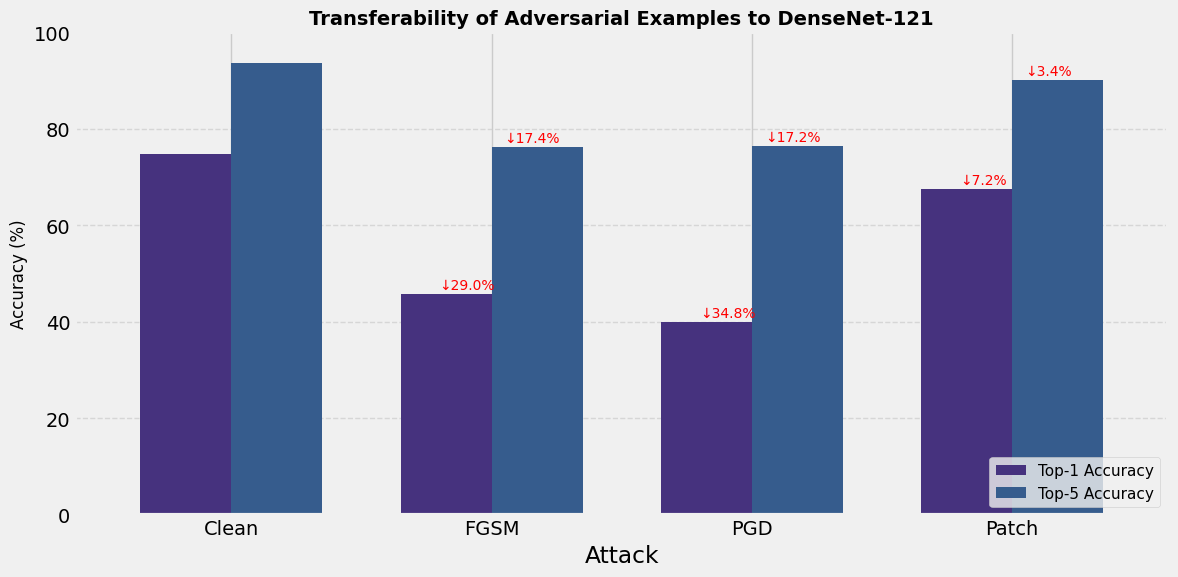

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_transferability_bar(results):
    """Plots clean vs adversarial accuracy with drop for each attack."""
    attack_types = ["Clean", "FGSM", "PGD", "Patch"]
    top1 = [results[atk.lower()]["top1"] for atk in attack_types]
    top5 = [results[atk.lower()]["top5"] for atk in attack_types]
    
    # Prepare data
    df = pd.DataFrame({
        "Attack": attack_types,
        "Top-1 Accuracy": top1,
        "Top-5 Accuracy": top5
    })
    
    # Plot
    plt.figure(figsize=(12, 6))
    ax = df.plot(x="Attack", kind="bar", rot=0, width=0.7, figsize=(12,6))
    plt.title("Transferability of Adversarial Examples to DenseNet-121", fontsize=14, fontweight='bold')
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.ylim(0, 100)
    
    # Add drop values on bars
    for i, atk in enumerate(attack_types[1:]):  # Skip "Clean"
        drop1 = results["clean"]["top1"] - results[atk.lower()]["top1"]
        drop5 = results["clean"]["top5"] - results[atk.lower()]["top5"]
        ax.text(i+1 - 0.2, top1[i+1] + 1, f"↓{drop1:.1f}%", fontsize=10, color='red')
        ax.text(i+1 + 0.05, top5[i+1] + 1, f"↓{drop5:.1f}%", fontsize=10, color='red')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', fontsize=11)
    plt.tight_layout()
    plt.show()
plot_transferability_bar(results)


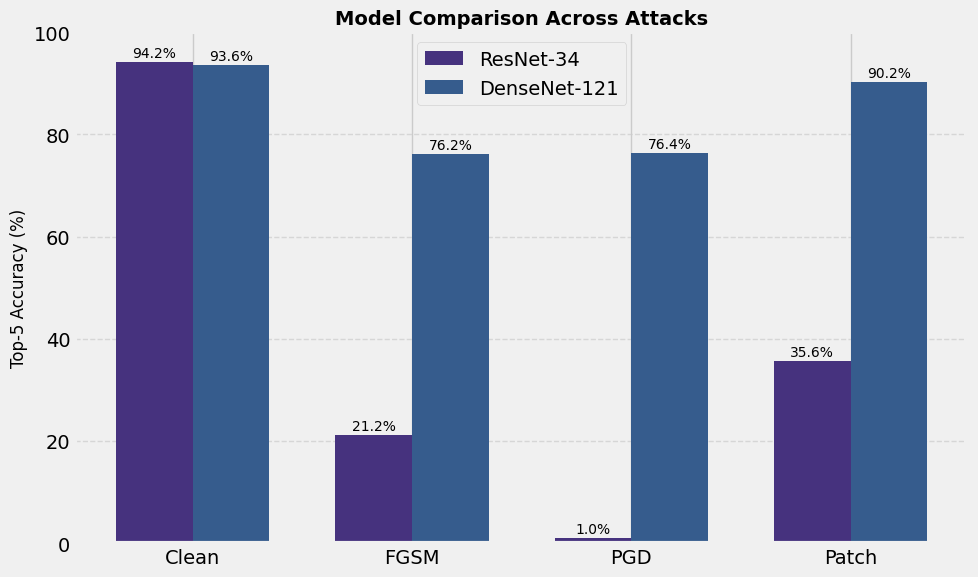

In [13]:
resnet_results = {
    'clean': {'top5': 94.2},
    'fgsm': {'top5': 21.2},
    'pgd': {'top5': 1.0},
    'patch': {'top5': 35.6}
}

densenet_results = {
    'clean': {'top5': 93.6},
    'fgsm': {'top5': 76.2},
    'pgd': {'top5': 76.4},
    'patch': {'top5': 90.2}
}

def plot_model_comparison(resnet_results, densenet_results):
    tasks = ["Clean", "FGSM", "PGD", "Patch"]
    resnet_acc = [resnet_results.get(t.lower(), {}).get("top5", 0) for t in tasks]
    densenet_acc = [densenet_results.get(t.lower(), {}).get("top5", 0) for t in tasks]
    
    x = np.arange(len(tasks))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, resnet_acc, width, label='ResNet-34')
    bars2 = ax.bar(x + width/2, densenet_acc, width, label='DenseNet-121')

    ax.set_ylabel('Top-5 Accuracy (%)', fontsize=12)
    ax.set_title('Model Comparison Across Attacks', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(tasks)
    ax.set_ylim(0, 100)
    ax.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height + 1),
                        ha='center', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
plot_model_comparison(resnet_results, densenet_results)

Generating adversarial examples:   0%|          | 0/16 [00:00<?, ?it/s]

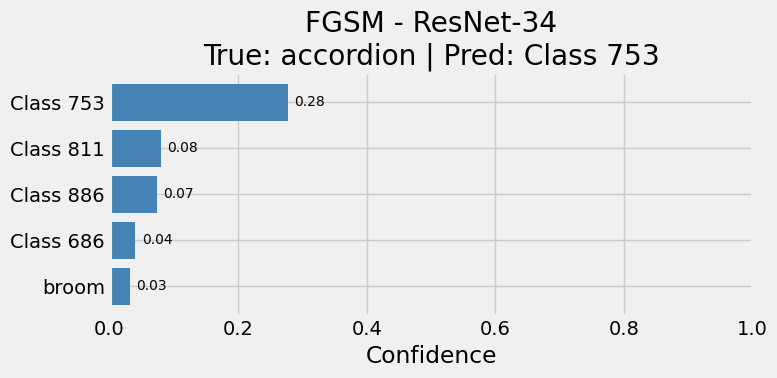

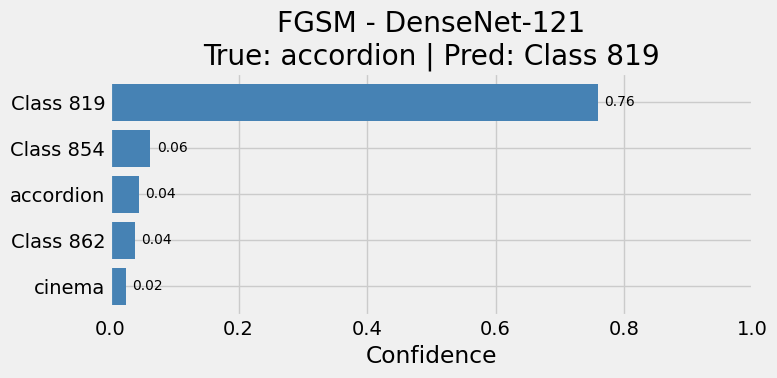

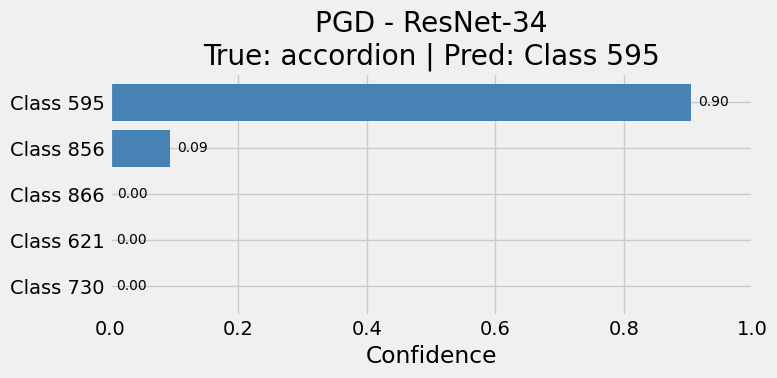

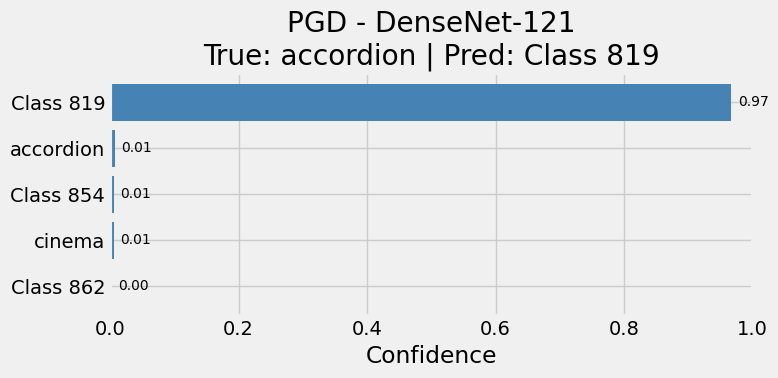

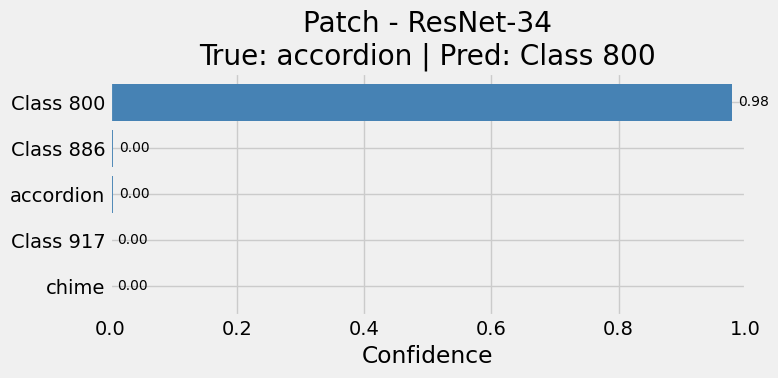

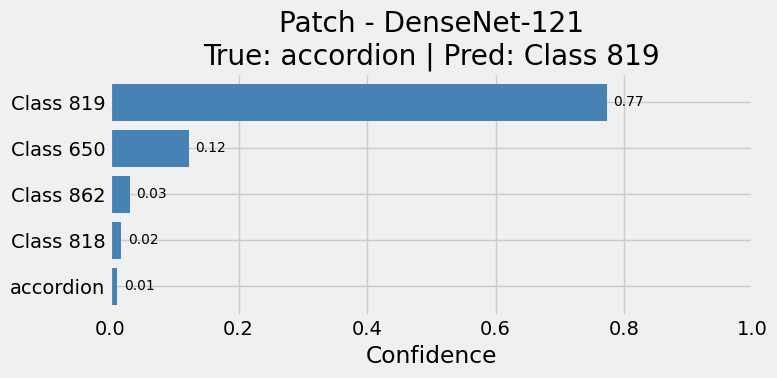

In [12]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def plot_top5_from_all_attacks(resnet, densenet, test_loader, class_names, batch_size=32):
    for attack_name in ["FGSM", "PGD", "Patch"]:
        for images, labels in test_loader:
            images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
            break

        # Generate adversarial examples using ResNet-34
        if attack_name == "FGSM":
            attacker = AdversarialAttacker(resnet, Config.DEVICE, 0.02)
            adv_dataset = attacker.generate_fgsm_attack(test_loader)
            adv_loader = DataLoader(adv_dataset, batch_size=batch_size, shuffle=False)
            adv_images, adv_labels = next(iter(adv_loader))
        else:
            if attack_name == "PGD":
                attack_fn = generate_pgd_attack
                attack_params = {'pgd_eps': 0.02, 'pgd_alpha': 0.005, 'pgd_steps': 10}
            else:
                attack_fn = generate_patch_attack
                attack_params = {'patch_size': 32, 'patch_eps': 0.5, 'patch_alpha': 0.12, 'pgd_steps': 20}

            adv_images, _, _ = attack_fn(
                model=resnet,
                images=images,
                labels=labels,
                loss_fn=torch.nn.CrossEntropyLoss(),
                mean_norms=Config.MEAN_NORMS,
                std_norms=Config.STD_NORMS,
                device=Config.DEVICE,
                **attack_params
            )

        # Evaluate on both ResNet and DenseNet
        for model_name, model in zip(["ResNet-34", "DenseNet-121"], [resnet, densenet]):
            model.eval()
            with torch.no_grad():
                outputs = model(adv_images.to(Config.DEVICE))
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)

            # Show first misclassified example
            for i in range(adv_images.size(0)):
                true = labels[i].item()
                pred = preds[i].item()
                if true != pred:
                    top5_vals, top5_idxs = torch.topk(probs[i], 5)
                    top5_vals = top5_vals.cpu().numpy()
                    top5_idxs = top5_idxs.cpu().numpy()

                    top5_labels = [class_names[c - 401] if 401 <= c < 501 else f"Class {c}" for c in top5_idxs]
                    true_label = class_names[true - 401] if 401 <= true < 501 else f"Class {true}"
                    pred_label = class_names[pred - 401] if 401 <= pred < 501 else f"Class {pred}"

                    plt.figure(figsize=(8, 4))
                    plt.barh(range(5), top5_vals[::-1], color='steelblue')
                    plt.yticks(range(5), top5_labels[::-1])
                    plt.xlim(0, 1.0)
                    plt.xlabel("Confidence")
                    plt.title(f"{attack_name} - {model_name}\nTrue: {true_label} | Pred: {pred_label}")
                    for j, v in enumerate(top5_vals[::-1]):
                        plt.text(v + 0.01, j, f"{v:.2f}", va='center', fontsize=10)
                    plt.tight_layout()
                    plt.show()
                    break
densenet_model = models.densenet121(weights='IMAGENET1K_V1').to(Config.DEVICE)

plot_top5_from_all_attacks(
    resnet=model, 
    densenet=densenet_model,
    test_loader=test_loader,
    class_names=data_manager.class_names,
    batch_size=32
)


#### Observations:

- **PGD transfers better** than FGSM in degrading DenseNet-121, despite both attacks being generated for ResNet-34. This suggests that **multi-step iterative methods produce more transferable perturbations**.
  
- **Patch attack transfers poorly**, resulting in only minor drops in accuracy. This is expected because the patch is localized and model-specific. Such attacks tend to exploit spatial biases that may not generalize across architectures.

- **Top-5 accuracy is more resilient** than Top-1, which is typical for high-class-count datasets like ImageNet.

- The **dense connectivity of DenseNet-121** might slightly improve its robustness compared to ResNet-34, but it remains vulnerable, especially to gradient-based attacks crafted on other models.



#### Lessons Learned:
- Similar architectures (CNNs trained on the same dataset) increase transfer success.
- Gradient-based attacks like FGSM and PGD are more transferable than L₀-constrained or spatial attacks.
- Attacks targeting global image structure generalize better than localized attacks.



#### Mitigation Ideas:
To defend against transferability:
- Use **adversarial training** with multiple models.
- Apply **randomization layers** or **input preprocessing** to break exact gradient paths.
- Ensemble multiple architectures for inference to reduce single-model overfitting to specific perturbations.
